# **Catatan**

- Kode program 1 adalah kalian tinggal running kode ini agar dapat melihat training dengan data asli tanpa dibersihkan, kemudian dievaluasi hasilnya dan dicatat. (running sendiri ya, kalau ada error screenshot kirim ke wa saya)
- hasil training dengan data asli (classification non-tuning) dibandingkan dengan hasil training data asli menggunakan hyperparameter tuning
- metric evaluasinya harus ada accuracy, precision, recall, dan f1-score

Kode ini untuk Topik ini:
- Phishing URL Detection Using BERT-Based Transformer Models
Topik Riset:
"Deteksi URL Phishing dengan Model Transformer Berbasis BERT: Studi Kasus Analisis URL dan Email"
Deskripsi:
Model BERT (Bidirectional Encoder Representations from Transformers) digunakan untuk memahami konteks URL atau teks email yang mencurigakan. Model ini dapat menganalisis karakter URL dan teks email untuk membedakan apakah mereka merupakan phishing atau tidak berdasarkan pola yang diidentifikasi dari dataset phishing.
Novelty: Sedang. Meskipun deteksi phishing berbasis URL sudah diteliti cukup luas, penggunaan BERT untuk klasifikasi URL secara mendalam masih relatif baru. Namun, karena banyak model sudah menggunakan BERT untuk analisis teks, tingkat novelty bisa lebih tinggi jika dilakukan kombinasi fitur tambahan seperti analisis perilaku pengguna.
Dataset: Malicious URL Dataset
Dataset ini berisi jutaan URL berbahaya, termasuk yang digunakan untuk phishing. BERT, sebagai model Transformer, dapat digunakan untuk memahami pola karakteristik URL dan memprediksi kemungkinan serangan phishing.
URL: Malicious URL Dataset​(GitHub)


# **Importing Modules and Libraries**

In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from os import path

# Sklearn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import GradScaler, autocast
from torch.optim import AdamW

# Transformers and progress bar
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm.auto import tqdm


In [ ]:
!pip install transformers tensorflow scikit-learn matplotlib pandas
!pip install transformers


# **Importing Datasets**

Mount Google Drive:

Digunakan untuk mengakses file yang disimpan di Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls


Mounted at /content/gdrive
gdrive	sample_data


Mengubah direktori kerja:

Ini digunakan untuk berpindah ke folder tempat dataset Anda berada.

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset")
!ls


 best_hyperparams_datadefault0.json   model_best_fold_2
 best_hyperparams_datadefault.json    model_best_fold_3
 classification_report.txt	      model_best_fold_4
 malicious_phish.csv		      model_best_fold_5
 Model				     'Salinan best_hyperparams_datadefault.json'
 model_best_fold_1


Memuat dataset:

Dataset **malicious_phish.csv** dimuat ke dalam variabel data.

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
print("Jumlah data asli:", len(data))
# data = data.sample(frac=0.0001, random_state=42).reset_index(drop=True)

# Mengambil xx% dari data secara acak
# ini sementara dilakukan karena resource yang dimiliki terbatas


Jumlah data asli: 651191


Menampilkan informasi awal tentang data:

Menampilkan 5 baris pertama dari dataset dan informasi tentang tipe data, jumlah entri, dan kolom yang ada di dalam dataset.

In [ ]:
data.head(n=5)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
# Misalkan kolom yang berisi label adalah 'type'
# Menampilkan nilai unik dan jumlah setiap kelas
kelas = data['type'].value_counts()
print(kelas)

# Menampilkan jumlah kelas unik
jumlah_kelas = data['type'].nunique()
print(f"Jumlah kelas unik: {jumlah_kelas}")


type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64
Jumlah kelas unik: 4


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
# Dimensions of the datasets after drop '-' in service column
print("(rows, columns):", data.shape)

(rows, columns): (651191, 2)


Ini adalah proses atau tahapan persiapan data yang baik sebelum dilanjutkan ke tahap analisis atau pemodelan.

# **Data Visualization**

In [ ]:
print(data.columns)


Index(['url', 'type'], dtype='object')


In [ ]:
print(data['type'].value_counts())


type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


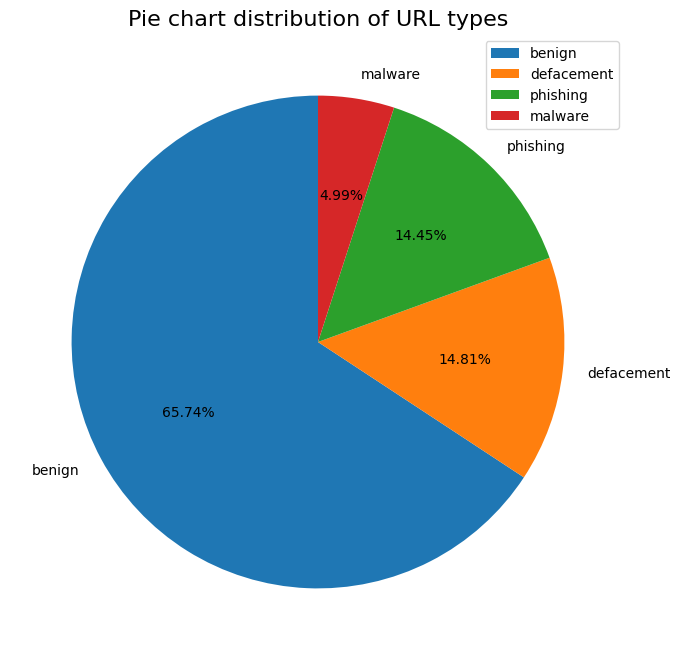

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset

# Hitung distribusi semua label
label_counts = data['type'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%0.2f%%', startangle=90)
plt.title("Pie chart distribution of URL types", fontsize=16)
plt.legend()
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/Pie_chart_all_classes.png')
plt.show()


# **DATA SPLITTING**

Jumlah data filtered: 522214
Jumlah data trim: 261


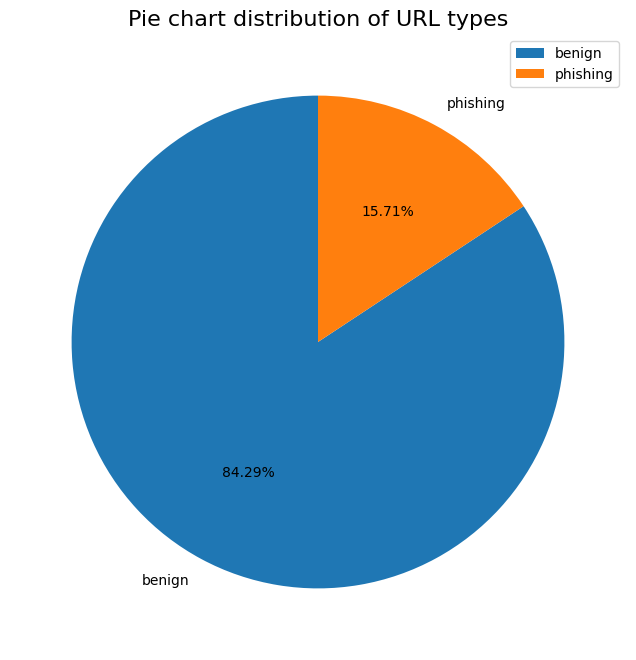

Ukuran set pelatihan: 208
Ukuran set pengujian: 53


In [ ]:
# # Memisahkan fitur dan label
# X_multi = data['url']  # Fitur: URL
# y_multi = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# Filter the data to keep only benign and phishing types
data_filtered = data[data['type'].isin(['benign', 'phishing'])]
print("Jumlah data filtered:", len(data_filtered))

data_filtered = data_filtered.sample(frac=0.0005, random_state=42).reset_index(drop=True)
print("Jumlah data trim:", len(data_filtered))

# Hitung distribusi semua label
label_counts = data_filtered['type'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%0.2f%%', startangle=90)
plt.title("Pie chart distribution of URL types", fontsize=16)
plt.legend()
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/Pie_chart_filter.png')
plt.show()

# Define features and labels
X_multi = data_filtered['url']  # Fitur: URL
y_multi = data_filtered['type'].map({'benign': 0, 'phishing': 1})  # Mengonversi label ke numerik


# Membagi data menjadi set pelatihan (80%) dan set pengujian (20%)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# Menampilkan informasi tentang ukuran set
print(f'Ukuran set pelatihan: {X_train_bin.shape[0]}')
print(f'Ukuran set pengujian: {X_test_bin.shape[0]}')


#2. TRANSFORMER "BERT"**

# **CLASSIFICATION Non-Tuning**

## tes0

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.cuda.amp import GradScaler, autocast

# # Initialize GradScaler
# scaler = torch.amp.GradScaler()

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)  # random_state untuk hasil yang konsisten

# # Memisahkan fitur dan label
# X = data['url']  # Fitur: URL
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# # 2. Initialize BERT tokenizer with clean_up_tokenization_spaces set
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []  # List to store average train losses for plotting
# average_val_accuracies = []  # List to store validation accuracies for plotting

# for fold, (train_index, val_index) in enumerate(kf.split(X)):
#     print(f'Fold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenization and tensor creation
#     train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
#     val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

#     # Initialize BERT model
#     model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y.unique()))
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model.to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#     # Train the model
#     num_epochs = 3
#     train_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         for batch in train_loader:
#             optimizer.zero_grad()
#             input_ids, attention_mask, labels = batch
#             input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

#             with torch.amp.autocast(device_type=device):
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(train_loader)
#         train_losses.append(avg_loss)

#         # Validate the model
#         model.eval()
#         with torch.no_grad():
#             val_input_ids = val_encodings['input_ids'].to(device)
#             val_attention_mask = val_encodings['attention_mask'].to(device)
#             outputs = model(val_input_ids, attention_mask=val_attention_mask)
#             y_pred = torch.argmax(outputs.logits, dim=1)

#         accuracy = accuracy_score(y_val, y_pred.cpu())
#         val_accuracies.append(accuracy)

#         # Save the best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Metrics calculation
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results for the current fold
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(), target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store average loss and accuracy for plotting
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix for the current fold
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()

# # 4. Average Metrics Across All Folds
# print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
# print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

# # 5. Plot the Average Confusion Matrix
# average_conf_matrix = np.mean(conf_matrix_list, axis=0)

# plt.figure(figsize=(8, 6))
# sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#             xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Average Confusion Matrix Across Folds')
# plt.show()

# # 6. Analysis of Results
# print("Hasil Deteksi Pola Enkripsi Ransomware:")
# for i, (acc, f1) in enumerate(zip(all_accuracy, all_f1_scores)):
#     print(f'Fold {i + 1}: Akurasi = {acc * 100:.2f}%, F1 Score = {f1:.4f}')

# # 7. Plot Loss and Accuracy for Each Fold
# for fold in range(len(average_train_losses)):
#     plt.figure(figsize=(12, 5))

#     # Grafik Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(average_train_losses[fold], label='Training Loss', marker='o')
#     plt.title(f'Training Loss for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid()

#     # Grafik Akurasi
#     plt.subplot(1, 2, 2)
#     plt.plot(average_val_accuracies[fold], label='Validation Accuracy', marker='o')
#     plt.title(f'Validation Accuracy for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.grid()

#     plt.tight_layout()
#     plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.amp import GradScaler, autocast
# from torch.optim import AdamW  # Using PyTorch's AdamW instead of transformers.optimization

# # Initialize gradient scaler with updated syntax
# scaler = GradScaler('cuda')

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)

# # Separate features and labels
# X = data['url']
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})

# # 2. Initialize BERT Tokenizer with clean_up_tokenization_spaces explicitly set
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []
# average_val_accuracies = []

# for fold, (train_index, val_index) in enumerate(kf.split(X)):
#     print(f'Fold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenization with explicit padding and truncation settings
#     train_encodings = tokenizer(
#         list(X_train),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )
#     val_encodings = tokenizer(
#         list(X_val),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

#     # Initialize BERT model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # Initialize optimizer using PyTorch's AdamW (removed no_deprecation_warning parameter)
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#        # Training loop
#     num_epochs = 3
#     train_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         batch_count = 0

#         for batch in train_loader:
#             # Clear gradients at the start of each batch
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 # Move batch to device and handle potential CUDA out of memory
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 # Forward pass with gradient scaling
#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 # Backward pass with gradient scaling
#                 scaler.scale(loss).backward()

#                 # Optimize and update scaler
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 # Accumulate loss
#                 current_loss = loss.item()
#                 epoch_loss += current_loss
#                 batch_count += 1

#                 # Print progress every 10 batches
#                 if batch_count % 10 == 0:
#                     print(f'Epoch {epoch+1}, Batch {batch_count}, Loss: {current_loss:.4f}')

#                 # Clear memory
#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         # Calculate average loss for the epoch
#         avg_loss = epoch_loss / max(batch_count, 1)  # Prevent division by zero
#         train_losses.append(avg_loss)
#         print(f'Epoch {epoch+1} completed, Average Loss: {avg_loss:.4f}')

#         # Validation step
#         model.eval()
#         val_predictions = []
#         val_labels = []

#         with torch.no_grad():
#             # Process validation data in smaller chunks
#             batch_size = 32  # Smaller batch size for validation
#             for i in range(0, len(val_encodings['input_ids']), batch_size):
#                 batch_end = min(i + batch_size, len(val_encodings['input_ids']))
#                 val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#                 val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)

#                 outputs = model(val_batch_input_ids, attention_mask=val_batch_attention_mask)
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)

#                 val_predictions.extend(batch_predictions.cpu().numpy())

#                 # Clear memory
#                 del outputs, batch_predictions
#                 torch.cuda.empty_cache()

#         # Calculate accuracy
#         accuracy = accuracy_score(y_val, val_predictions)
#         val_accuracies.append(accuracy)
#         print(f'Validation Accuracy: {accuracy:.4f}')

#         # Model saving and early stopping
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Metrics calculation
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(),
#                                     target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store metrics for plotting
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()



## Tes1

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.amp import GradScaler, autocast
# from torch.optim import AdamW
# from tqdm.auto import tqdm  # Import tqdm for progress bars

# # Initialize gradient scaler with updated syntax
# scaler = GradScaler('cuda')

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)

# # Separate features and labels
# X = data['url']
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})

# # 2. Initialize BERT Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []
# average_val_accuracies = []

# # Progress bar for folds
# for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X), total=5, desc='Folds')):
#     print(f'\nFold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Progress bar for tokenization
#     print("Tokenizing training data...")
#     train_encodings = tokenizer(
#         list(tqdm(X_train)),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     print("Tokenizing validation data...")
#     val_encodings = tokenizer(
#         list(tqdm(X_val)),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader with increased batch size
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Increased batch size to 64

#     # Initialize BERT model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#     # Training loop
#     num_epochs = 3
#     train_losses = []
#     val_accuracies = []

#     # Progress bar for epochs
#     for epoch in tqdm(range(num_epochs), desc='Epochs'):
#         model.train()
#         epoch_loss = 0
#         batch_count = 0

#         # Progress bar for batches
#         pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
#         for batch in pbar:
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 scaler.scale(loss).backward()

#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 current_loss = loss.item()
#                 epoch_loss += current_loss
#                 batch_count += 1

#                 # Update progress bar description with current loss
#                 pbar.set_postfix({'loss': f'{current_loss:.4f}'})

#                 # Print progress every 10 batches
#                 if batch_count % 500 == 0:
#                     print(f'Epoch {epoch+1}, Batch {batch_count}, Loss: {current_loss:.4f}')

#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         avg_loss = epoch_loss / max(batch_count, 1)
#         train_losses.append(avg_loss)
#         print(f'Epoch {epoch+1} completed, Average Loss: {avg_loss:.4f}')

#         # Validation step
#         model.eval()
#         val_predictions = []

#         with torch.no_grad():
#             # Progress bar for validation
#             for i in tqdm(range(0, len(val_encodings['input_ids']), 64), desc='Validating'):  # Increased batch size to 64
#                 batch_end = min(i + 64, len(val_encodings['input_ids']))
#                 val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#                 val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)

#                 outputs = model(val_batch_input_ids, attention_mask=val_batch_attention_mask)
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)

#                 val_predictions.extend(batch_predictions.cpu().numpy())

#                 del outputs, batch_predictions
#                 torch.cuda.empty_cache()

#         # Calculate metrics
#         accuracy = accuracy_score(y_val, val_predictions)
#         val_accuracies.append(accuracy)
#         print(f'Validation Accuracy: {accuracy:.4f}')

#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Calculate final metrics
#     y_pred = torch.tensor(val_predictions)
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(),
#                                     target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store metrics
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()

## tes2

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.amp import GradScaler, autocast
# from torch.optim import AdamW

# # Print hyperparameters
# print("Using default hyperparameters: nhead=8, d_model=256, dropout=0.1, lr=5e-5, batch_size=32")

# # Initialize gradient scaler
# scaler = GradScaler('cuda')

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)

# # Separate features and labels
# X = data['url']
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})

# # Initialize BERT Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# num_epochs = 3

# for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
#     print(f"\nFold {fold}/5")

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenization
#     # Progress bar for tokenization
#     print("Tokenizing training data...")
#     train_encodings = tokenizer(
#         list(tqdm(X_train)),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     print("Tokenizing validation data...")
#     val_encodings = tokenizer(
#         list(tqdm(X_val)),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#     # Initialize model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Training variables
#     best_accuracy = 0
#     best_val_loss = float('inf')

#     def compute_validation_metrics():
#         model.eval()
#         total_val_loss = 0
#         val_predictions = []

#         with torch.no_grad():
#             for i in range(0, len(val_encodings['input_ids']), 32):
#                 batch_end = min(i + 32, len(val_encodings['input_ids']))
#                 val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#                 val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)
#                 val_batch_labels = y_val_tensor[i:batch_end].to(device)

#                 outputs = model(val_batch_input_ids,
#                               attention_mask=val_batch_attention_mask,
#                               labels=val_batch_labels)

#                 total_val_loss += outputs.loss.item()
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)
#                 val_predictions.extend(batch_predictions.cpu().numpy())

#                 del outputs, batch_predictions
#                 torch.cuda.empty_cache()

#         val_loss = total_val_loss / (len(val_encodings['input_ids']) / 32)
#         accuracy = accuracy_score(y_val, val_predictions)
#         f1 = f1_score(y_val, val_predictions, average='weighted')

#         return val_loss, accuracy, f1, val_predictions

#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         batch_count = 0

#         for batch in train_loader:
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 total_train_loss += loss.item()
#                 batch_count += 1

#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         # Calculate average training loss
#         avg_train_loss = total_train_loss / batch_count

#         # Compute validation metrics
#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics()

#         # Print progress
#         print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
#               f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, "
#               f"F1 Score: {f1:.4f}")

#         # Save best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     # After fold completion, compute final confusion matrix
#     _, _, _, final_predictions = compute_validation_metrics()
#     conf_matrix = confusion_matrix(y_val, final_predictions)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold}')
#     plt.show()

## tes3

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.amp import GradScaler, autocast
# from torch.optim import AdamW
# from tqdm.auto import tqdm

# # Print hyperparameters
# print("Using default hyperparameters: nhead=8, d_model=256, dropout=0.1, lr=5e-5, batch_size=64")

# # Initialize gradient scaler
# scaler = GradScaler('cuda')

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.1, random_state=1)

# # Separate features and labels
# X = data['url']
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})

# # Initialize BERT Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# num_epochs = 3

# # Progress bar for folds
# for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X), total=5, desc='Folds', position=0), 1):
#     print(f"\nFold {fold}/5")

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Progress bar for train tokenization
#     print("Tokenizing training data...")
#     train_texts = list(X_train)
#     train_encodings = tokenizer(
#         [text for text in tqdm(train_texts, desc='Train Tokenization', position=1)],
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Progress bar for validation tokenization
#     print("Tokenizing validation data...")
#     val_texts = list(X_val)
#     val_encodings = tokenizer(
#         [text for text in tqdm(val_texts, desc='Val Tokenization', position=1)],
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#     # Initialize model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Training variables
#     best_accuracy = 0
#     best_val_loss = float('inf')

#     def compute_validation_metrics():
#         model.eval()
#         total_val_loss = 0
#         val_predictions = []

#         # Progress bar for validation batches
#         val_iterator = range(0, len(val_encodings['input_ids']), 64)
#         with torch.no_grad():
#             for i in tqdm(val_iterator, desc='Validation', position=2, leave=False):
#                 batch_end = min(i + 64, len(val_encodings['input_ids']))
#                 val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#                 val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)
#                 val_batch_labels = y_val_tensor[i:batch_end].to(device)

#                 outputs = model(val_batch_input_ids,
#                               attention_mask=val_batch_attention_mask,
#                               labels=val_batch_labels)

#                 total_val_loss += outputs.loss.item()
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)
#                 val_predictions.extend(batch_predictions.cpu().numpy())

#                 del outputs, batch_predictions
#                 torch.cuda.empty_cache()

#         val_loss = total_val_loss / (len(val_encodings['input_ids']) / 64)
#         accuracy = accuracy_score(y_val, val_predictions)
#         f1 = f1_score(y_val, val_predictions, average='weighted')

#         return val_loss, accuracy, f1, val_predictions

#     # Training loop with progress bar for epochs
#     for epoch in tqdm(range(num_epochs), desc='Epochs', position=1):
#         model.train()
#         total_train_loss = 0
#         batch_count = 0

#         # Progress bar for batches
#         train_iterator = tqdm(train_loader, desc=f'Training batches', position=2, leave=False)
#         for batch in train_iterator:
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 current_loss = loss.item()
#                 total_train_loss += current_loss
#                 batch_count += 1

#                 # Update progress bar description with current loss
#                 train_iterator.set_description(f'Training (loss: {current_loss:.4f})')

#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         # Calculate average training loss
#         avg_train_loss = total_train_loss / batch_count

#         # Compute validation metrics
#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics()

#         # Print progress
#         print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
#               f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, "
#               f"F1 Score: {f1:.4f}")

#         # Save best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     # After fold completion, compute final confusion matrix
#     _, _, _, final_predictions = compute_validation_metrics()
#     conf_matrix = confusion_matrix(y_val, final_predictions)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold}')
#     plt.show()

## tes4

### 4a

In [ ]:
# # Initialize gradient scaler
# scaler = GradScaler('cuda')

# # # K-Fold dan Epoch
# k_folds = 5
# num_epochs = 3

# # # Hyperparameters
# # input_dim = X_train_bin.shape[1]
# # num_classes = len(class_names)
# # nhead = 8
# # d_model = 256
# # dropout = 0.1
# lr = 5e-5
# batch_size = 64

# model_dir = './Model/Default'
# os.makedirs(model_dir, exist_ok=True)

# # Assume you have already split the data into training and testing sets
# # Using X_train_bin, X_test_bin, y_train_bin, y_test_bin directly from your earlier split

# # Initialize BERT Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # KFold Cross-Validation
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# # num_epochs = 3
# #X_train_bin, X_test_bin, y_train_bin, y_test_bin

# # Initialize lists for storing metrics across all folds
# all_labels = []
# all_preds = []
# fold_results = []
# # Progress bar for folds
# for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X_train_bin), total=5, desc='Folds', position=0), 1):
#     print(f"Fold {fold + 1}/{k_folds}")

#     # Split data
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     # Progress bar for train tokenization
#     print("Tokenizing training data...")
#     train_texts = list(X_train)
#     train_encodings = tokenizer(
#         [text for text in tqdm(train_texts, desc='Train Tokenization', position=1)],
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Progress bar for validation tokenization
#     print("Tokenizing validation data...")
#     val_texts = list(X_val)
#     val_encodings = tokenizer(
#         [text for text in tqdm(val_texts, desc='Val Tokenization', position=1)],
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)

#     # Create DataLoader for validation
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)
#     val_loader = DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True  )

#     # Initialize model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_train_bin.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # # Model, loss, and optimizer
#     # model = TransformerModel(input_dim=input_dim, num_classes=num_classes, nhead=nhead, d_model=d_model, dropout=dropout).to(device)
#     # criterion = nn.CrossEntropyLoss()

#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Training variables
#     best_accuracy = 0
#     best_val_loss = float('inf')
#     total_val_loss = 0
#     def compute_validation_metrics():
#         model.eval()

#         val_predictions = []
#         total_val_loss = 0  # Define total_val_loss as a local variable


#         # Progress bar for validation batches
#         val_iterator = range(0, len(val_encodings['input_ids']), 64)
#         # with torch.no_grad():
#         #     for i in tqdm(val_iterator, desc='Validation', position=2, leave=False):
#         #         batch_end = min(i + 64, len(val_encodings['input_ids']))
#         #         val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#         #         val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)
#         #         val_batch_labels = y_val_tensor[i:batch_end].to(device)

#         #         outputs = model(val_batch_input_ids,
#         #                       attention_mask=val_batch_attention_mask,
#         #                       labels=val_batch_labels)

#         #         total_val_loss += outputs.loss.item()
#         #         batch_predictions = torch.argmax(outputs.logits, dim=1)
#         #         val_predictions.extend(batch_predictions.cpu().numpy())

#         #         del outputs, batch_predictions
#         #         torch.cuda.empty_cache()
#         with torch.no_grad():
#             for batch in val_loader:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#                 total_val_loss += loss.item()
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)
#                 val_predictions.extend(batch_predictions.cpu().numpy())


#         val_loss = total_val_loss / (len(val_encodings['input_ids']) / 64)
#         accuracy = accuracy_score(y_val, val_predictions)
#         f1 = f1_score(y_val, val_predictions, average='weighted')

#         return val_loss, accuracy, f1, val_predictions

#     # Training loop with progress bar for epochs
#     for epoch in tqdm(range(num_epochs), desc='Epochs', position=1):
#         model.train()
#         total_train_loss = 0
#         batch_count = 0

#         # Progress bar for batches
#         train_iterator = tqdm(train_loader, desc=f'Training batches', position=2, leave=False)
#         for batch in train_iterator:
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 current_loss = loss.item()
#                 total_train_loss += current_loss
#                 batch_count += 1

#                 # Update progress bar description with current loss
#                 train_iterator.set_description(f'Training (loss: {current_loss:.4f})')

#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         # Calculate average training loss
#         avg_train_loss = total_train_loss / batch_count
#         avg_val_loss = total_val_loss / len(val_loader)

#         # Compute validation metrics
#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics()

#         # Print progress
#         print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
#               f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, "
#               f"F1 Score: {f1:.4f}")

#         # Save best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#         # Save predictions and true labels after each fold
#         fold_results.append((avg_train_loss, avg_val_loss, accuracy, f1))
#         all_labels.extend(y_val)  # Collect true labels from validation set
#         all_preds.extend(val_predictions)  # Collect predictions


#     # Calculate and display average metrics across folds
#     avg_metrics = {key: np.mean([result[idx] for result in fold_results])
#                   for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])}

#     print("\nAverage Metrics Across Folds:")
#     for key, value in avg_metrics.items():
#         print(f"{key.capitalize()}: {value:.4f}")

#     # After fold completion, compute final confusion matrix
#     _, _, _, final_predictions = compute_validation_metrics()
#     conf_matrix = confusion_matrix(y_val, final_predictions)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold}')
#     plt.show()

#     # Classification report
#     # print("\nClassification Report Across All Folds:")
#     # print(classification_report(all_labels, all_preds, target_names=class_names))

### 4c

In [ ]:
# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# batch_size = 64
# lr = 5e-5
# k_folds = 5
# num_epochs = 3

# # Load tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     model.eval()
#     val_predictions = []
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions

# def train_and_evaluate(fold, train_loader, val_loader, y_val):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)
#     optimizer = AdamW(model.parameters(), lr=lr)
#     scaler = GradScaler() if torch.cuda.is_available() else None
#     best_accuracy = 0

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training'):
#             optimizer.zero_grad(set_to_none=True)
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]

#             with autocast(device_type='cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#             if scaler:
#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()

#             total_train_loss += loss.item()
#             torch.cuda.empty_cache()

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1, _ = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
#               f"Accuracy = {accuracy*100:.2f}%, F1 Score = {f1:.4f}")

#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     return avg_train_loss, val_loss, accuracy, f1

# # Main KFold loop
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# fold_results = []
# for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#     print(f"Fold {fold}/{k_folds}")
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     train_encodings = tokenize_data(list(X_train))
#     val_encodings = tokenize_data(list(X_val))

#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#     fold_results.append(train_and_evaluate(fold, train_loader, val_loader, y_val))

# # Display results across folds
# avg_metrics = {key: np.mean([result[idx] for result in fold_results])
#               for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])}
# print("Average Metrics Across Folds:")
# for key, value in avg_metrics.items():
#     print(f"{key.capitalize()}: {value:.4f}")

### 4c

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Fold 1/5


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Fold 1 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss = 0.4002, Val Loss = 0.3952, Accuracy = 86.30%, F1 Score = 0.7996
Saved best model for fold 1 at epoch 1.


Epoch 2 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 2: Train Loss = 0.3478, Val Loss = 0.2268, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 3: Train Loss = 0.2278, Val Loss = 0.1685, Accuracy = 93.15%, F1 Score = 0.9214
Saved best model for fold 1 at epoch 3.
Average Metrics Across Folds:
Train_loss: 0.2278
Val_loss: 0.1685
Accuracy: 0.9315
F1_score: 0.9214


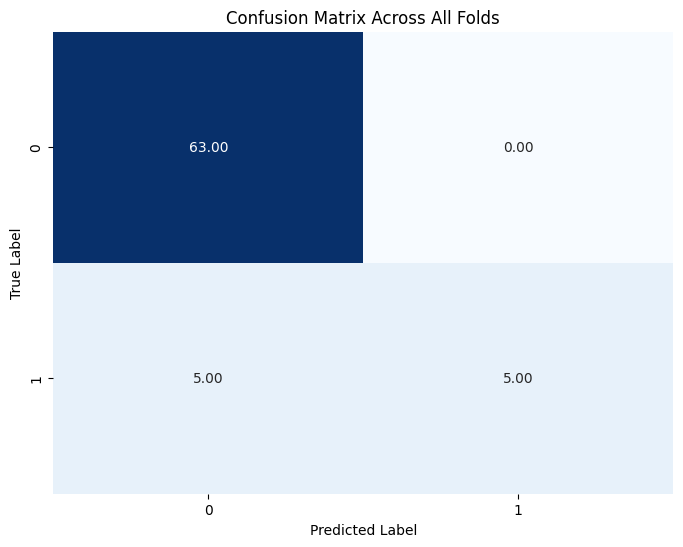


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.9265    1.0000    0.9618        63
           1     1.0000    0.5000    0.6667        10

    accuracy                         0.9315        73
   macro avg     0.9632    0.7500    0.8142        73
weighted avg     0.9365    0.9315    0.9214        73

Fold 2/5


Fold 2 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss = 0.4099, Val Loss = 0.3249, Accuracy = 86.30%, F1 Score = 0.7996
Saved best model for fold 2 at epoch 1.


Epoch 2 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 2: Train Loss = 0.2939, Val Loss = 0.2611, Accuracy = 86.30%, F1 Score = 0.8214


Epoch 3 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 3: Train Loss = 0.1706, Val Loss = 0.2887, Accuracy = 87.67%, F1 Score = 0.8740
Saved best model for fold 2 at epoch 3.
Average Metrics Across Folds:
Train_loss: 0.1992
Val_loss: 0.2286
Accuracy: 0.9041
F1_score: 0.8977


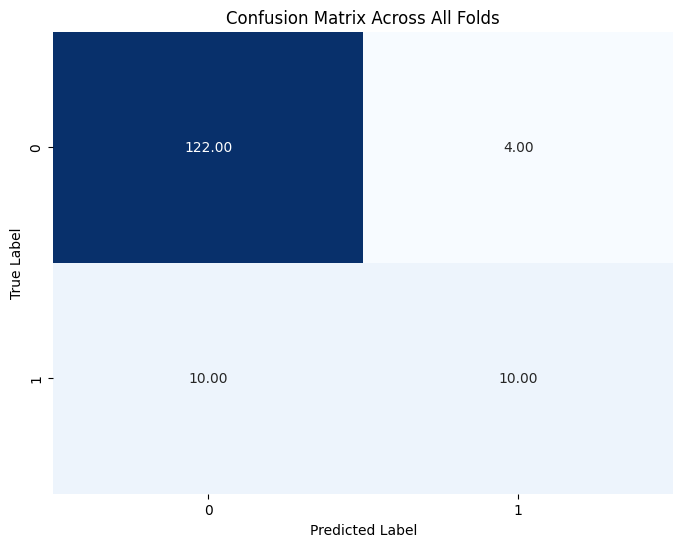


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.9242    0.9683    0.9457       126
           1     0.7143    0.5000    0.5882        20

    accuracy                         0.9041       146
   macro avg     0.8193    0.7341    0.7670       146
weighted avg     0.8955    0.9041    0.8968       146

Fold 3/5


Fold 3 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss = 0.5443, Val Loss = 0.3534, Accuracy = 86.30%, F1 Score = 0.7996
Saved best model for fold 3 at epoch 1.


Epoch 2 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 2: Train Loss = 0.2668, Val Loss = 0.2673, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 3: Train Loss = 0.2284, Val Loss = 0.1603, Accuracy = 93.15%, F1 Score = 0.9263
Saved best model for fold 3 at epoch 3.
Average Metrics Across Folds:
Train_loss: 0.2089
Val_loss: 0.2058
Accuracy: 0.9132
F1_score: 0.9072


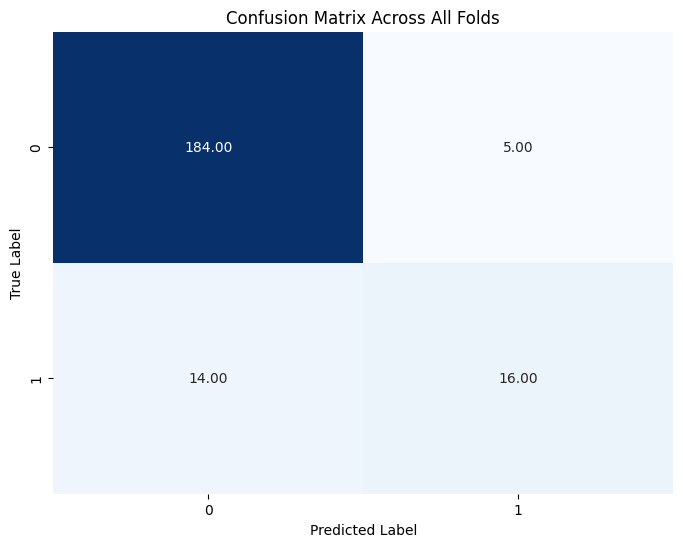


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.9293    0.9735    0.9509       189
           1     0.7619    0.5333    0.6275        30

    accuracy                         0.9132       219
   macro avg     0.8456    0.7534    0.7892       219
weighted avg     0.9064    0.9132    0.9066       219

Fold 4/5


Fold 4 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss = 0.4463, Val Loss = 0.3829, Accuracy = 87.67%, F1 Score = 0.8191
Saved best model for fold 4 at epoch 1.


Epoch 2 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 2: Train Loss = 0.2823, Val Loss = 0.3279, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 3: Train Loss = 0.2149, Val Loss = 0.3447, Accuracy = 94.52%, F1 Score = 0.9382
Saved best model for fold 4 at epoch 3.
Average Metrics Across Folds:
Train_loss: 0.2104
Val_loss: 0.2405
Accuracy: 0.9212
F1_score: 0.9150


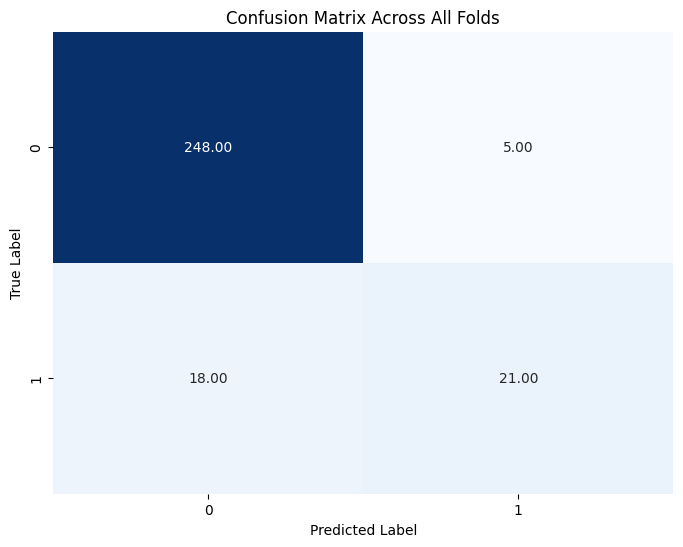


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.9323    0.9802    0.9557       253
           1     0.8077    0.5385    0.6462        39

    accuracy                         0.9212       292
   macro avg     0.8700    0.7593    0.8009       292
weighted avg     0.9157    0.9212    0.9143       292

Fold 5/5


Fold 5 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss = 0.4740, Val Loss = 0.3036, Accuracy = 86.30%, F1 Score = 0.7996
Saved best model for fold 5 at epoch 1.


Epoch 2 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 2: Train Loss = 0.2424, Val Loss = 0.2701, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 3: Train Loss = 0.2388, Val Loss = 0.1402, Accuracy = 87.67%, F1 Score = 0.8792
Saved best model for fold 5 at epoch 3.
Average Metrics Across Folds:
Train_loss: 0.2161
Val_loss: 0.2205
Accuracy: 0.9123
F1_score: 0.9078


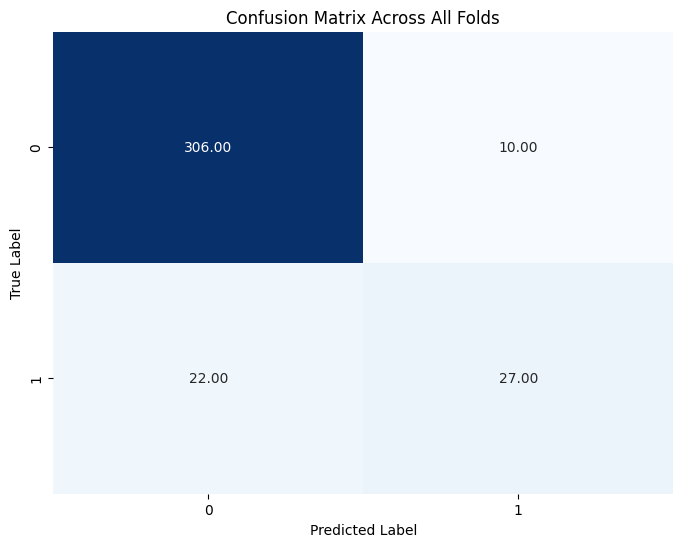


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.9329    0.9684    0.9503       316
           1     0.7297    0.5510    0.6279        49

    accuracy                         0.9123       365
   macro avg     0.8313    0.7597    0.7891       365
weighted avg     0.9056    0.9123    0.9070       365



In [ ]:
# import transformers
# from contextlib import nullcontext
# from sklearn.metrics import accuracy_score, f1_score  # Ensure these imports are included
# # Ensure imports for confusion matrix and plotting
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report
# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# batch_size = 32
# lr = 5e-5
# k_folds = 5
# num_epochs = 3

# # Load tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     val_predictions = []
#     model.eval()
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions  # Ensure val_predictions is returned# Update train_and_evaluate to capture val_predictions properly
# def train_and_evaluate(fold, train_loader, val_loader, y_val):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     scaler = GradScaler() if torch.cuda.is_available() else None
#     best_accuracy = 0

#     for epoch in tqdm(range(num_epochs), desc=f'Fold {fold} - Epoch', leave=False):
#         model.train()
#         total_train_loss = 0
#         for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training', leave=False):
#             optimizer.zero_grad(set_to_none=True)
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]

#             with autocast(device_type='cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#             if scaler:
#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()

#             total_train_loss += loss.item()
#             torch.cuda.empty_cache()

#         avg_train_loss = total_train_loss / len(train_loader)

#         # Call compute_validation_metrics and capture all returned values
#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
#               f"Accuracy = {accuracy*100:.2f}%, F1 Score = {f1:.4f}")

#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     return avg_train_loss, val_loss, accuracy, f1, val_predictions


# # Metrics collection
# all_labels = []
# all_preds = []
# fold_results = []

# # Main KFold loop with updates
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#     print(f"Fold {fold}/{k_folds}")
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     train_encodings = tokenize_data(list(X_train))
#     val_encodings = tokenize_data(list(X_val))

#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#     # Train and evaluate for the current fold
#     avg_train_loss, val_loss, accuracy, f1, val_predictions = train_and_evaluate(fold, train_loader, val_loader, y_val)
#     fold_results.append((avg_train_loss, val_loss, accuracy, f1))

#     # Collect predictions and true labels
#     all_labels.extend(y_val.tolist())
#     all_preds.extend(val_predictions)  # Use the returned val_predictions here


#     ### HASIL RUNNING ###
#     # Display average metrics across folds
#     avg_metrics = {key: np.mean([result[idx] for result in fold_results])
#                   for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])}
#     print("Average Metrics Across Folds:")
#     for key, value in avg_metrics.items():
#         print(f"{key.capitalize()}: {value:.4f}")

#     # Calculate and plot the overall confusion matrix after all folds
#     conf_matrix = confusion_matrix(all_labels, all_preds)

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
#     plt.title("Confusion Matrix Across All Folds")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

#     # Classification report for all folds
#     print("\nClassification Report for All Folds:")
#     print(classification_report(all_labels, all_preds, digits=4))


### 4d

In [ ]:
import transformers
from contextlib import nullcontext
from sklearn.metrics import accuracy_score, f1_score  # Ensure these imports are included
# Ensure imports for confusion matrix and plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score  # Tambahkan impor untuk roc_auc_score

# Set transformers logging to error only
transformers.logging.set_verbosity_error()

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
lr = 5e-5
k_folds = 5
num_epochs = 3

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

def tokenize_data(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='pt',
        max_length=512
    )

def compute_validation_metrics(model, val_loader, y_val):
    val_predictions = []
    val_probs = []  # Tambahkan list untuk menyimpan probabilitas prediksi
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            batch_probs = torch.softmax(outputs.logits, dim=1)  # Hitung probabilitas dengan softmax
            batch_predictions = torch.argmax(outputs.logits, dim=1)

            val_predictions.extend(batch_predictions.cpu().numpy())
            val_probs.extend(batch_probs.cpu().numpy())  # Simpan probabilitas

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions, average='weighted')
    return avg_val_loss, accuracy, f1, val_predictions, val_probs  # Tambahkan val_probs untuk AUC-ROC

def train_and_evaluate(fold, train_loader, val_loader, y_val):
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=len(y_val.unique()),
        problem_type="single_label_classification"
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scaler = GradScaler() if torch.cuda.is_available() else None
    best_accuracy = 0

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold} - Epoch', leave=False):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training', leave=False):
            optimizer.zero_grad(set_to_none=True)
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            with autocast(device_type='cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_train_loss += loss.item()
            torch.cuda.empty_cache()

        avg_train_loss = total_train_loss / len(train_loader)

        # Panggil compute_validation_metrics dan tangkap val_probs untuk AUC-ROC
        val_loss, accuracy, f1, val_predictions, val_probs = compute_validation_metrics(model, val_loader, y_val)

        # Hitung AUC-ROC untuk setiap epoch
        if len(np.unique(y_val)) == 2:
            # Jika hanya dua kelas, ambil probabilitas kelas positif
            epoch_roc_auc = roc_auc_score(y_val, [prob[1] for prob in val_probs])
        else:
            # Untuk multi-kelas
            epoch_roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
              f"Accuracy = {accuracy*100:.2f}%, F1 Score = {f1:.4f}, AUC-ROC = {epoch_roc_auc:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model.save_pretrained(f'model_best_fold_{fold}')
            print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

    return avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs


# Metrics collection
all_labels = []  # Ubah ke list kosong
all_probs = []   # Ubah ke list kosong
all_preds = []
fold_results = []

# Main KFold loop with updates
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
    print(f"Fold {fold}/{k_folds}")
    X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
    y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

    train_encodings = tokenize_data(list(X_train))
    val_encodings = tokenize_data(list(X_val))

    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Train and evaluate for the current fold
    avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs = train_and_evaluate(fold, train_loader, val_loader, y_val)
    fold_results.append((avg_train_loss, val_loss, accuracy, f1))

    # Collect predictions and true labels
    all_labels.extend(y_val.tolist())
    all_preds.extend(val_predictions)
    all_probs.extend(val_probs)  # Simpan probabilitas untuk AUC-ROC

Fold 1/5


Fold 1 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.2968, Val Loss = 0.2360, Accuracy = 92.62%, F1 Score = 0.9242, AUC-ROC = 0.9559
Saved best model for fold 1 at epoch 1.


Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.1512, Val Loss = 0.2319, Accuracy = 92.90%, F1 Score = 0.9277, AUC-ROC = 0.9750
Saved best model for fold 1 at epoch 2.


Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.0998, Val Loss = 0.3030, Accuracy = 92.08%, F1 Score = 0.9185, AUC-ROC = 0.9605
Fold 2/5


Fold 2 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3468, Val Loss = 0.2844, Accuracy = 87.16%, F1 Score = 0.8822, AUC-ROC = 0.9388
Saved best model for fold 2 at epoch 1.


Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.2175, Val Loss = 0.2051, Accuracy = 90.71%, F1 Score = 0.9131, AUC-ROC = 0.9764
Saved best model for fold 2 at epoch 2.


Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.1517, Val Loss = 0.1772, Accuracy = 93.72%, F1 Score = 0.9388, AUC-ROC = 0.9708
Saved best model for fold 2 at epoch 3.
Fold 3/5


Fold 3 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3079, Val Loss = 0.2014, Accuracy = 93.97%, F1 Score = 0.9360, AUC-ROC = 0.9595
Saved best model for fold 3 at epoch 1.


Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.1551, Val Loss = 0.1673, Accuracy = 93.97%, F1 Score = 0.9406, AUC-ROC = 0.9607


Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.0825, Val Loss = 0.3092, Accuracy = 94.79%, F1 Score = 0.9465, AUC-ROC = 0.9323
Saved best model for fold 3 at epoch 3.
Fold 4/5


Fold 4 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3009, Val Loss = 0.2896, Accuracy = 92.88%, F1 Score = 0.9250, AUC-ROC = 0.8551
Saved best model for fold 4 at epoch 1.


Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.1981, Val Loss = 0.1681, Accuracy = 93.42%, F1 Score = 0.9353, AUC-ROC = 0.9753
Saved best model for fold 4 at epoch 2.


Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.1512, Val Loss = 0.1564, Accuracy = 95.89%, F1 Score = 0.9583, AUC-ROC = 0.9721
Saved best model for fold 4 at epoch 3.
Fold 5/5


Fold 5 - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3274, Val Loss = 0.2052, Accuracy = 93.42%, F1 Score = 0.9338, AUC-ROC = 0.9454
Saved best model for fold 5 at epoch 1.


Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.1701, Val Loss = 0.1495, Accuracy = 94.79%, F1 Score = 0.9465, AUC-ROC = 0.9676
Saved best model for fold 5 at epoch 2.


Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.1123, Val Loss = 0.1911, Accuracy = 95.07%, F1 Score = 0.9507, AUC-ROC = 0.9512
Saved best model for fold 5 at epoch 3.


In [ ]:
# Jika hanya ada dua kelas, pastikan bentuk probabilitas cocok
if len(np.unique(all_labels)) == 2:
    # Ambil probabilitas untuk kelas positif (kelas 1)
    all_probs = np.array([prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, all_probs)
else:
    # Untuk multi-kelas, biarkan all_probs dalam bentuk asli
    all_probs = np.array(all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"Average AUC-ROC Across All Folds: {roc_auc:.4f}")

Average AUC-ROC Across All Folds: 0.9300


Average Metrics Across Folds:
Train loss: 0.1195
Val loss: 0.2274
Accuracy: 0.9431
F1 score: 0.9426
Auc roc: 0.9300


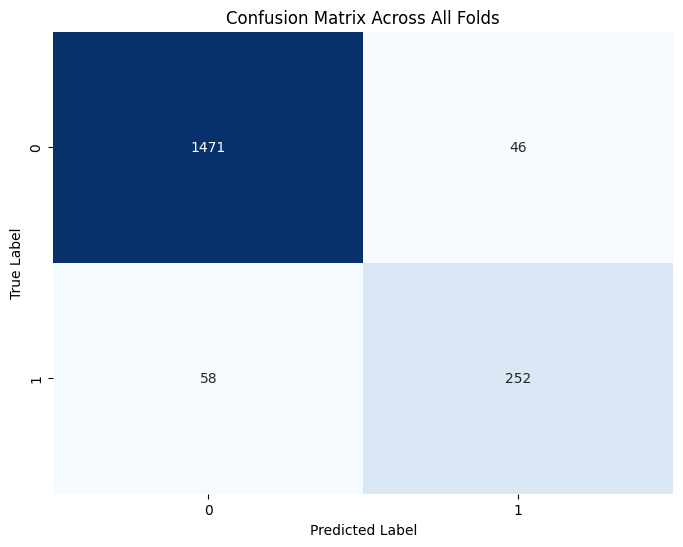


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.9621    0.9697    0.9659      1517
           1     0.8456    0.8129    0.8289       310

    accuracy                         0.9431      1827
   macro avg     0.9039    0.8913    0.8974      1827
weighted avg     0.9423    0.9431    0.9426      1827


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.9621    0.9697    0.9659      1517
           1     0.8456    0.8129    0.8289       310

    accuracy                         0.9431      1827
   macro avg     0.9039    0.8913    0.8974      1827
weighted avg     0.9423    0.9431    0.9426      1827



In [ ]:
# Average Metrics Across Folds
avg_metrics = {
    key: np.mean([result[idx] for result in fold_results])
    for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])
}
avg_metrics['auc_roc'] = roc_auc  # Tambahkan AUC-ROC rata-rata

print("Average Metrics Across Folds:")
for key, value in avg_metrics.items():
    print(f"{key.replace('_', ' ').capitalize()}: {value:.4f}")

# Calculate and plot the overall confusion matrix after all folds
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.title("Confusion Matrix Across All Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report = classification_report(all_labels, all_preds, digits=4)
print("\nClassification Report for All Folds:")
print(report)

with open("classification_report.txt", "w") as f:
    f.write(report)


# Classification Report for All Folds
print("\nClassification Report for All Folds:")
print(classification_report(all_labels, all_preds, digits=4))


# **Fine Tuning Hyperparameter**

**Tidak perlu run lagi jika sudah pernah, karena prosesnya akan lama (81 kombinasi)**

## tes0

In [ ]:
# !pip install optuna


In [ ]:
# import pandas as pd
# import numpy as np
# import optuna
# import torch
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import KFold
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from torch.utils.data import DataLoader, TensorDataset

# # Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')

# # Memisahkan fitur dan label
# X = data['url']  # Fitur: URL
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# # Inisialisasi Tokenizer BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# def train_model(trial):
#     # Hyperparameter tuning
#     batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
#     num_epochs = trial.suggest_int('num_epochs', 3, 10)

#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     all_accuracy = []

#     for train_index, val_index in kf.split(X):
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#         # Tokenisasi dan pembuatan tensor
#         train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
#         val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

#         # Convert labels to tensors
#         y_train_tensor = torch.LongTensor(y_train.values)
#         y_val_tensor = torch.LongTensor(y_val.values)

#         # Create DataLoader
#         train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#         # Initialize BERT model
#         model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y.unique()))
#         model.to('cuda' if torch.cuda.is_available() else 'cpu')
#         optimizer = AdamW(model.parameters(), lr=learning_rate, )

#         # Train the model
#         for epoch in range(num_epochs):
#             model.train()
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 input_ids, attention_mask, labels = batch
#                 input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#                 loss.backward()
#                 optimizer.step()

#         # Validate the model
#         model.eval()
#         with torch.no_grad():
#             val_input_ids = val_encodings['input_ids'].to('cuda')
#             val_attention_mask = val_encodings['attention_mask'].to('cuda')
#             outputs = model(val_input_ids, attention_mask=val_attention_mask)
#             y_pred = torch.argmax(outputs.logits, dim=1)

#         accuracy = accuracy_score(y_val, y_pred.cpu())
#         all_accuracy.append(accuracy)

#     # Return average accuracy across folds
#     return np.mean(all_accuracy)

# # Create a study object for hyperparameter optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(train_model, n_trials=20)

# # Print the best hyperparameters
# print("Best hyperparameters: ", study.best_params)
# print("Best accuracy: ", study.best_value)


In [ ]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from sklearn.model_selection import KFold, ParameterGrid
# from sklearn.metrics import accuracy_score, f1_score
# from torch.utils.data import DataLoader, TensorDataset
# from tqdm import tqdm
# import transformers

# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_epochs = 4  # Set to 4 as per your output example

# # Load tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     model.eval()
#     val_predictions = []
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions

# def train_and_evaluate(fold, train_loader, val_loader, y_val, batch_size, lr):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     best_val_loss = float('inf')

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         # Progress bar for training
#         with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', leave=False) as pbar:
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#                 loss.backward()
#                 optimizer.step()
#                 total_train_loss += loss.item()

#                 pbar.set_postfix(loss=loss.item())
#                 pbar.update(1)

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1, _ = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss = {avg_train_loss:.4f}, Validation Loss = {val_loss:.4f}, "
#               f"Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.4f}")

#     return best_val_loss

# # Hyperparameter grid
# param_grid = {
#     'batch_size': [32, 64],
#     'd_model': [128, 256],
#     'dropout': [0.1, 0.2],
#     'lr': [0.001, 0.0001],
#     'nhead': [4, 8]
# }

# # Metrics collection
# best_hyperparams = None
# best_val_loss = float('inf')

# # Main KFold loop
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Iterate through all combinations of parameters
# for params in ParameterGrid(param_grid):
#     print(f"Evaluating params: {params}")

#     for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#         print(f"Fold {fold}/5")
#         X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#         y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#         train_encodings = tokenize_data(list(X_train))
#         val_encodings = tokenize_data(list(X_val))

#         y_train_tensor = torch.LongTensor(y_train.values).to(device)
#         y_val_tensor = torch.LongTensor(y_val.values).to(device)

#         train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#         val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#         train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

#         val_loss = train_and_evaluate(fold, train_loader, val_loader, y_val, params['batch_size'], params['lr'])

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_hyperparams = params

# print("\nBest Hyperparameters:")
# print(f"Parameters: {best_hyperparams}")
# print(f"Best Average Validation Loss: {best_val_loss:.4f}")


## tes1

In [ ]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from sklearn.model_selection import KFold, ParameterGrid
# from sklearn.metrics import accuracy_score, f1_score
# from torch.utils.data import DataLoader, TensorDataset
# from tqdm import tqdm
# import transformers

# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_epochs = 4  # Set to 4 as per your output example

# # Load tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     model.eval()
#     val_predictions = []
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val.cpu(), val_predictions)
#     f1 = f1_score(y_val.cpu(), val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1

# def train_and_evaluate(fold, train_loader, val_loader, y_val, batch_size, lr):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     best_val_loss = float('inf')

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         # Progress bar for training
#         with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', leave=False) as pbar:
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#                 loss.backward()
#                 optimizer.step()

#                 total_train_loss += loss.item()
#                 pbar.set_postfix(loss=loss.item())
#                 pbar.update(1)

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1 = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss = {avg_train_loss:.4f}, "
#               f"Validation Loss = {val_loss:.4f}, Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.4f}")

#         # Check if the validation loss has improved
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss

#     return best_val_loss

# # Hyperparameter grid
# # Hyperparameter grid
# param_grid = {
#     'nhead': [4, 8, 16],
#     'd_model': [128, 256, 512],
#     'dropout': [0.1],
#     'lr': [1e-3],
#     'batch_size': [32]
# }

# # Metrics collection
# best_hyperparams = None
# best_val_loss = float('inf')

# # Main KFold loop
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Iterate through all combinations of parameters
# for params in ParameterGrid(param_grid):
#     print(f"Evaluating params: {params}")

#     for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#         print(f"Fold {fold}/5")
#         X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#         y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#         train_encodings = tokenize_data(list(X_train))
#         val_encodings = tokenize_data(list(X_val))

#         y_train_tensor = torch.LongTensor(y_train.values).to(device)
#         y_val_tensor = torch.LongTensor(y_val.values).to(device)

#         train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#         val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#         train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

#         val_loss = train_and_evaluate(fold, train_loader, val_loader, y_val_tensor, params['batch_size'], params['lr'])

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_hyperparams = params

# print("\nBest Hyperparameters:")
# print(f"Parameters: {best_hyperparams}")
# print(f"Best Average Validation Loss: {best_val_loss:.4f}")


Evaluating params: {'batch_size': 32, 'd_model': 128, 'dropout': 0.1, 'lr': 0.001, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7383, Validation Loss = 0.4418, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3981, Validation Loss = 0.4085, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3853, Validation Loss = 0.4095, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4005, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6555, Validation Loss = 0.3895, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4186, Validation Loss = 0.3974, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3837, Validation Loss = 0.3963, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4551, Validation Loss = 0.4045, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7195, Validation Loss = 0.4082, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4888, Validation Loss = 2.2536, Accuracy = 13.70%, F1 Score = 0.0330


Epoch 3/4: Training Loss = 0.7834, Validation Loss = 0.4288, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3887, Validation Loss = 0.3976, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6936, Validation Loss = 0.5231, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4207, Validation Loss = 0.4176, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.3823, Validation Loss = 0.4178, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.3818, Validation Loss = 0.4191, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.9134, Validation Loss = 0.4203, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4718, Validation Loss = 0.3970, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4505, Validation Loss = 0.4170, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4335, Validation Loss = 0.3946, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 128, 'dropout': 0.1, 'lr': 0.001, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5728, Validation Loss = 0.4615, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4656, Validation Loss = 0.3904, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.6377, Validation Loss = 0.5391, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.5072, Validation Loss = 0.3882, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5689, Validation Loss = 0.4688, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4861, Validation Loss = 0.3880, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.7127, Validation Loss = 0.5417, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4603, Validation Loss = 0.4023, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7371, Validation Loss = 0.4470, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3884, Validation Loss = 0.4304, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3994, Validation Loss = 0.3947, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4241, Validation Loss = 0.4148, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5104, Validation Loss = 0.5619, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4322, Validation Loss = 0.4776, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4792, Validation Loss = 0.4231, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.3954, Validation Loss = 0.4467, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5415, Validation Loss = 0.3883, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4511, Validation Loss = 0.4055, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4424, Validation Loss = 0.4248, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.6142, Validation Loss = 0.5279, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 128, 'dropout': 0.1, 'lr': 0.001, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4947, Validation Loss = 0.4079, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4416, Validation Loss = 0.3889, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4586, Validation Loss = 0.3971, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3743, Validation Loss = 0.3884, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6688, Validation Loss = 0.3882, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4040, Validation Loss = 0.5100, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.5549, Validation Loss = 0.4614, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.5431, Validation Loss = 0.4078, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7494, Validation Loss = 0.3898, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3708, Validation Loss = 0.3898, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3891, Validation Loss = 0.4020, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4282, Validation Loss = 0.3986, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6038, Validation Loss = 0.4232, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.5497, Validation Loss = 0.4185, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.9164, Validation Loss = 0.4711, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.4086, Validation Loss = 0.4245, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6269, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4197, Validation Loss = 0.3970, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4514, Validation Loss = 0.3935, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4197, Validation Loss = 0.3882, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 0.001, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7046, Validation Loss = 0.4061, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4010, Validation Loss = 0.3952, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3852, Validation Loss = 0.3901, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3808, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5430, Validation Loss = 0.3883, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3948, Validation Loss = 0.3976, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4066, Validation Loss = 0.4180, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3926, Validation Loss = 0.3884, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5735, Validation Loss = 0.4285, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4103, Validation Loss = 0.3952, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4209, Validation Loss = 0.4966, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4528, Validation Loss = 0.3891, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4695, Validation Loss = 0.4186, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4322, Validation Loss = 0.4275, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.3908, Validation Loss = 0.5092, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.4006, Validation Loss = 0.4201, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5064, Validation Loss = 0.4078, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3963, Validation Loss = 0.4015, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4251, Validation Loss = 0.4407, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3723, Validation Loss = 0.4064, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 0.001, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.8435, Validation Loss = 0.3823, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3973, Validation Loss = 0.3929, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4365, Validation Loss = 0.3919, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3869, Validation Loss = 0.4042, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4647, Validation Loss = 0.4439, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4180, Validation Loss = 0.4188, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4537, Validation Loss = 0.4180, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4812, Validation Loss = 0.3884, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7564, Validation Loss = 0.4473, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4833, Validation Loss = 0.4571, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4095, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4290, Validation Loss = 0.3883, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7561, Validation Loss = 0.7749, Accuracy = 12.33%, F1 Score = 0.0271


Epoch 2/4: Training Loss = 0.4665, Validation Loss = 0.4472, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.3944, Validation Loss = 0.4964, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.4273, Validation Loss = 0.4176, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5441, Validation Loss = 0.3933, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.5730, Validation Loss = 0.3917, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4652, Validation Loss = 0.3898, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4325, Validation Loss = 0.3892, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 0.001, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7919, Validation Loss = 0.5633, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.5470, Validation Loss = 0.4302, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4892, Validation Loss = 0.4095, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3799, Validation Loss = 0.4017, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.2857, Validation Loss = 1.9583, Accuracy = 13.70%, F1 Score = 0.0330


Epoch 2/4: Training Loss = 0.9179, Validation Loss = 0.6047, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4718, Validation Loss = 0.3882, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3923, Validation Loss = 0.3881, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6197, Validation Loss = 0.4664, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4921, Validation Loss = 0.4371, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.8931, Validation Loss = 0.5027, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.5015, Validation Loss = 0.3993, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6353, Validation Loss = 0.4215, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.3854, Validation Loss = 0.4949, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4840, Validation Loss = 0.4179, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.3753, Validation Loss = 0.4943, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5714, Validation Loss = 0.3902, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4246, Validation Loss = 0.4136, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4479, Validation Loss = 0.3889, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3775, Validation Loss = 0.4141, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 0.001, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.2231, Validation Loss = 0.4237, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4302, Validation Loss = 0.4859, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4081, Validation Loss = 0.4100, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4029, Validation Loss = 0.3916, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.8212, Validation Loss = 0.3926, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4070, Validation Loss = 0.4041, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4888, Validation Loss = 0.3945, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4691, Validation Loss = 0.4040, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4427, Validation Loss = 0.4504, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4315, Validation Loss = 0.3882, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.7900, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3841, Validation Loss = 0.4017, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4704, Validation Loss = 0.4601, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4125, Validation Loss = 0.4181, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4248, Validation Loss = 0.4203, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.3885, Validation Loss = 0.4181, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4540, Validation Loss = 0.4200, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4488, Validation Loss = 0.3974, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4330, Validation Loss = 0.3951, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3703, Validation Loss = 0.4288, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 0.001, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.0566, Validation Loss = 0.5166, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3927, Validation Loss = 0.5478, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4941, Validation Loss = 0.3889, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3875, Validation Loss = 0.3908, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.5116, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4545, Validation Loss = 0.4463, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4083, Validation Loss = 0.4013, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3857, Validation Loss = 0.3885, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4930, Validation Loss = 0.3922, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3979, Validation Loss = 0.3978, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4152, Validation Loss = 0.3903, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4219, Validation Loss = 0.4036, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.9359, Validation Loss = 0.9021, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.6250, Validation Loss = 0.4214, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4315, Validation Loss = 0.4177, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.3997, Validation Loss = 0.4340, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.4816, Validation Loss = 0.3879, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4732, Validation Loss = 0.5393, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4154, Validation Loss = 0.4109, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4130, Validation Loss = 0.4248, Accuracy = 86.30%, F1 Score = 0.7996
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 0.001, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.0460, Validation Loss = 0.4437, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4257, Validation Loss = 0.4577, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.4315, Validation Loss = 0.3912, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4281, Validation Loss = 0.3913, Accuracy = 86.30%, F1 Score = 0.7996
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.9290, Validation Loss = 0.4519, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.3885, Validation Loss = 0.3911, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3832, Validation Loss = 0.3947, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.3926, Validation Loss = 0.3889, Accuracy = 86.30%, F1 Score = 0.7996
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.7236, Validation Loss = 0.5427, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4713, Validation Loss = 0.4491, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3903, Validation Loss = 0.4089, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4346, Validation Loss = 0.4136, Accuracy = 86.30%, F1 Score = 0.7996
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 0.6963, Validation Loss = 0.4681, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 2/4: Training Loss = 0.4150, Validation Loss = 0.4567, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 3/4: Training Loss = 0.4265, Validation Loss = 0.4439, Accuracy = 87.67%, F1 Score = 0.8191


Epoch 4/4: Training Loss = 0.4112, Validation Loss = 0.4216, Accuracy = 87.67%, F1 Score = 0.8191
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4: Training Loss = 1.1837, Validation Loss = 0.3940, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 2/4: Training Loss = 0.4972, Validation Loss = 0.3918, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 3/4: Training Loss = 0.3944, Validation Loss = 0.4568, Accuracy = 86.30%, F1 Score = 0.7996


Epoch 4/4: Training Loss = 0.4600, Validation Loss = 0.4186, Accuracy = 86.30%, F1 Score = 0.7996

Best Hyperparameters:
Parameters: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 0.001, 'nhead': 8}
Best Average Validation Loss: 0.3823


## tes2

In [ ]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from sklearn.model_selection import KFold, ParameterGrid
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# from torch.utils.data import DataLoader, TensorDataset
# from tqdm import tqdm
# import transformers

# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_epochs = 3 # Set to 4 as per your output example

# # Load tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     model.eval()
#     val_predictions = []
#     val_probs = []
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_probs = torch.softmax(outputs.logits, dim=1)
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())
#             val_probs.extend(batch_probs.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val.cpu(), val_predictions)
#     f1 = f1_score(y_val.cpu(), val_predictions, average='weighted')

#     # Compute AUC-ROC
#     if len(set(y_val.cpu().numpy())) == 2:
#         auc_roc = roc_auc_score(y_val.cpu(), [p[1] for p in val_probs])
#     else:
#         auc_roc = roc_auc_score(y_val.cpu(), val_probs, multi_class='ovr')

#     return avg_val_loss, accuracy, f1, auc_roc

# def train_and_evaluate(fold, train_loader, val_loader, y_val, batch_size, lr):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     best_val_loss = float('inf')
#     best_auc_roc = 0.0  # Initialize best AUC-ROC

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', leave=False) as pbar:
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#                 loss.backward()
#                 optimizer.step()

#                 total_train_loss += loss.item()
#                 pbar.set_postfix(loss=loss.item())
#                 pbar.update(1)

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1, auc_roc = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss = {avg_train_loss:.4f}, "
#               f"Validation Loss = {val_loss:.4f}, Accuracy = {accuracy * 100:.2f}%, "
#               f"F1 Score = {f1:.4f}, AUC-ROC = {auc_roc:.4f}")

#         # Track best model based on validation loss or AUC-ROC
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_auc_roc = auc_roc  # Update best AUC-ROC for this val_loss
#             best_model_state = model.state_dict()

#     model.load_state_dict(best_model_state)  # Load best model for final evaluation
#     return best_val_loss, best_auc_roc

# # Hyperparameter grid
# # param_grid = {
# #     'nhead': [4, 8, 16],
# #     'd_model': [128, 256, 512],
# #     'dropout': [0.1],
# #     'lr': [1e-3],
# #     'batch_size': [32]
# # }
# param_grid = {
#     'nhead': [4, 8, 16],
#     'd_model': [256, 512, 768],
#     'dropout': [0.1],
#     'lr': [1e-5, 3e-5, 5e-5],
#     'batch_size': [32]
# }

# # Metrics collection
# best_hyperparams = None
# best_val_loss = float('inf')
# best_auc_roc = 0.0

# # Main KFold loop
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for params in ParameterGrid(param_grid):
#     print(f"Evaluating params: {params}")

#     for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#         print(f"Fold {fold}/5")
#         X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#         y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#         train_encodings = tokenize_data(list(X_train))
#         val_encodings = tokenize_data(list(X_val))

#         y_train_tensor = torch.LongTensor(y_train.values).to(device)
#         y_val_tensor = torch.LongTensor(y_val.values).to(device)

#         train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#         val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#         train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

#         val_loss, auc_roc = train_and_evaluate(fold, train_loader, val_loader, y_val_tensor, params['batch_size'], params['lr'])

#         if val_loss < best_val_loss or auc_roc > best_auc_roc:
#             best_val_loss = val_loss
#             best_auc_roc = auc_roc
#             best_hyperparams = params

# print("\nBest Hyperparameters:")
# print(f"Parameters: {best_hyperparams}")
# print(f"Best Average Validation Loss: {best_val_loss:.4f}")
# print(f"Best Average AUC-ROC: {best_auc_roc:.4f}")


Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5835, Validation Loss = 0.4000, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7667


Epoch 2/3: Training Loss = 0.3981, Validation Loss = 0.3667, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7079


Epoch 3/3: Training Loss = 0.3305, Validation Loss = 0.2848, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9460
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4846, Validation Loss = 0.4071, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5429


Epoch 2/3: Training Loss = 0.4498, Validation Loss = 0.3747, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7698


Epoch 3/3: Training Loss = 0.3490, Validation Loss = 0.3202, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8587
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4422, Validation Loss = 0.3859, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6810


Epoch 2/3: Training Loss = 0.3512, Validation Loss = 0.3574, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8444


Epoch 3/3: Training Loss = 0.3516, Validation Loss = 0.3462, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8571
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5518, Validation Loss = 0.4399, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6354


Epoch 2/3: Training Loss = 0.4624, Validation Loss = 0.4028, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7639


Epoch 3/3: Training Loss = 0.3798, Validation Loss = 0.3805, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8837
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5618, Validation Loss = 0.4332, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.3794


Epoch 2/3: Training Loss = 0.3995, Validation Loss = 0.3773, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7651


Epoch 3/3: Training Loss = 0.3509, Validation Loss = 0.3645, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8921
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4164, Validation Loss = 0.3831, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7714


Epoch 2/3: Training Loss = 0.3580, Validation Loss = 0.3477, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9651


Epoch 3/3: Training Loss = 0.3239, Validation Loss = 0.2969, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9746
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5452, Validation Loss = 0.4035, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6333


Epoch 2/3: Training Loss = 0.4543, Validation Loss = 0.3937, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5349


Epoch 3/3: Training Loss = 0.3820, Validation Loss = 0.3901, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6492
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4150, Validation Loss = 0.3853, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7190


Epoch 2/3: Training Loss = 0.3630, Validation Loss = 0.3645, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8492


Epoch 3/3: Training Loss = 0.3522, Validation Loss = 0.3225, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8841
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4988, Validation Loss = 0.4279, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.4497


Epoch 2/3: Training Loss = 0.4193, Validation Loss = 0.4185, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6215


Epoch 3/3: Training Loss = 0.4215, Validation Loss = 0.3741, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9080
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5236, Validation Loss = 0.3741, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8841


Epoch 2/3: Training Loss = 0.3568, Validation Loss = 0.3570, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9381


Epoch 3/3: Training Loss = 0.3716, Validation Loss = 0.3327, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9317
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6845, Validation Loss = 0.4201, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6524


Epoch 2/3: Training Loss = 0.4144, Validation Loss = 0.3701, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8873


Epoch 3/3: Training Loss = 0.3898, Validation Loss = 0.3379, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9317
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6506, Validation Loss = 0.4862, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5889


Epoch 2/3: Training Loss = 0.4099, Validation Loss = 0.3587, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8873


Epoch 3/3: Training Loss = 0.3613, Validation Loss = 0.2975, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9079
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.7773, Validation Loss = 0.3314, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9222


Epoch 2/3: Training Loss = 0.3467, Validation Loss = 0.3456, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9175


Epoch 3/3: Training Loss = 0.3118, Validation Loss = 0.3205, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8587
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6473, Validation Loss = 0.4606, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.2622


Epoch 2/3: Training Loss = 0.3916, Validation Loss = 0.3681, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8993


Epoch 3/3: Training Loss = 0.3560, Validation Loss = 0.3018, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9306
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6024, Validation Loss = 0.4117, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8571


Epoch 2/3: Training Loss = 0.3807, Validation Loss = 0.3327, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9492


Epoch 3/3: Training Loss = 0.3087, Validation Loss = 0.2812, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8921
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4656, Validation Loss = 0.3839, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8603


Epoch 2/3: Training Loss = 0.3386, Validation Loss = 0.2957, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9302


Epoch 3/3: Training Loss = 0.2865, Validation Loss = 0.2139, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8937
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4121, Validation Loss = 0.3489, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8397


Epoch 2/3: Training Loss = 0.3348, Validation Loss = 0.2948, Accuracy = 84.93%, F1 Score = 0.8669, AUC-ROC = 0.9190


Epoch 3/3: Training Loss = 0.2164, Validation Loss = 0.2791, Accuracy = 83.56%, F1 Score = 0.8559, AUC-ROC = 0.9016
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5229, Validation Loss = 0.3806, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6905


Epoch 2/3: Training Loss = 0.3252, Validation Loss = 0.3226, Accuracy = 87.67%, F1 Score = 0.8740, AUC-ROC = 0.9048


Epoch 3/3: Training Loss = 0.2425, Validation Loss = 0.2824, Accuracy = 87.67%, F1 Score = 0.8740, AUC-ROC = 0.8587
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5324, Validation Loss = 0.4172, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6215


Epoch 2/3: Training Loss = 0.3963, Validation Loss = 0.3317, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8715


Epoch 3/3: Training Loss = 0.2520, Validation Loss = 0.3001, Accuracy = 91.78%, F1 Score = 0.9073, AUC-ROC = 0.8837
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3658, Validation Loss = 0.3293, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8730


Epoch 2/3: Training Loss = 0.2878, Validation Loss = 0.2548, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9476


Epoch 3/3: Training Loss = 0.2365, Validation Loss = 0.1710, Accuracy = 89.04%, F1 Score = 0.8572, AUC-ROC = 0.9762
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5043, Validation Loss = 0.3743, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9270


Epoch 2/3: Training Loss = 0.3458, Validation Loss = 0.3081, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9571


Epoch 3/3: Training Loss = 0.2613, Validation Loss = 0.1951, Accuracy = 93.15%, F1 Score = 0.9351, AUC-ROC = 0.9460
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5074, Validation Loss = 0.3757, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7968


Epoch 2/3: Training Loss = 0.3001, Validation Loss = 0.2497, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9238


Epoch 3/3: Training Loss = 0.2251, Validation Loss = 0.2191, Accuracy = 87.67%, F1 Score = 0.8585, AUC-ROC = 0.9460
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3840, Validation Loss = 0.3687, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8254


Epoch 2/3: Training Loss = 0.3370, Validation Loss = 0.3448, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9032


Epoch 3/3: Training Loss = 0.3031, Validation Loss = 0.2877, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9079
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5188, Validation Loss = 0.4169, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8125


Epoch 2/3: Training Loss = 0.3656, Validation Loss = 0.3903, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8854


Epoch 3/3: Training Loss = 0.3533, Validation Loss = 0.3129, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9132
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4828, Validation Loss = 0.3692, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8937


Epoch 2/3: Training Loss = 0.3339, Validation Loss = 0.2969, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9317


Epoch 3/3: Training Loss = 0.2613, Validation Loss = 0.2394, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9571
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4779, Validation Loss = 0.3636, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8651


Epoch 2/3: Training Loss = 0.3342, Validation Loss = 0.2911, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8984


Epoch 3/3: Training Loss = 0.2611, Validation Loss = 0.2252, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9302
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5714, Validation Loss = 0.3751, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6873


Epoch 2/3: Training Loss = 0.3399, Validation Loss = 0.2968, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9270


Epoch 3/3: Training Loss = 0.2733, Validation Loss = 0.2418, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9333
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5363, Validation Loss = 0.3801, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7143


Epoch 2/3: Training Loss = 0.4105, Validation Loss = 0.3701, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8206


Epoch 3/3: Training Loss = 0.3231, Validation Loss = 0.3395, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8667
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5425, Validation Loss = 0.4392, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5764


Epoch 2/3: Training Loss = 0.3948, Validation Loss = 0.2938, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9358


Epoch 3/3: Training Loss = 0.2588, Validation Loss = 0.2650, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9479
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4216, Validation Loss = 0.3925, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8413


Epoch 2/3: Training Loss = 0.3743, Validation Loss = 0.3479, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9778


Epoch 3/3: Training Loss = 0.3209, Validation Loss = 0.2787, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9587
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4683, Validation Loss = 0.3926, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7159


Epoch 2/3: Training Loss = 0.3704, Validation Loss = 0.2713, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9730


Epoch 3/3: Training Loss = 0.2297, Validation Loss = 0.1674, Accuracy = 93.15%, F1 Score = 0.9214, AUC-ROC = 0.9286
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4241, Validation Loss = 0.3801, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7222


Epoch 2/3: Training Loss = 0.3343, Validation Loss = 0.2498, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9222


Epoch 3/3: Training Loss = 0.1829, Validation Loss = 0.3326, Accuracy = 89.04%, F1 Score = 0.9024, AUC-ROC = 0.9349
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3882, Validation Loss = 0.3808, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8746


Epoch 2/3: Training Loss = 0.3332, Validation Loss = 0.2969, Accuracy = 84.93%, F1 Score = 0.8523, AUC-ROC = 0.8952


Epoch 3/3: Training Loss = 0.1668, Validation Loss = 0.2902, Accuracy = 87.67%, F1 Score = 0.8891, AUC-ROC = 0.8603
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4006, Validation Loss = 0.3880, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9323


Epoch 2/3: Training Loss = 0.3574, Validation Loss = 0.3417, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9236


Epoch 3/3: Training Loss = 0.2582, Validation Loss = 0.2934, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9392
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5148, Validation Loss = 0.3868, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6778


Epoch 2/3: Training Loss = 0.4069, Validation Loss = 0.3276, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8016


Epoch 3/3: Training Loss = 0.2715, Validation Loss = 0.2618, Accuracy = 90.41%, F1 Score = 0.8808, AUC-ROC = 0.9143
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4226, Validation Loss = 0.2872, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9667


Epoch 2/3: Training Loss = 0.2859, Validation Loss = 0.2016, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8683


Epoch 3/3: Training Loss = 0.1969, Validation Loss = 0.1818, Accuracy = 91.78%, F1 Score = 0.9021, AUC-ROC = 0.9508
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4700, Validation Loss = 0.4106, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4619


Epoch 2/3: Training Loss = 0.3927, Validation Loss = 0.3748, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8651


Epoch 3/3: Training Loss = 0.3437, Validation Loss = 0.2817, Accuracy = 84.93%, F1 Score = 0.8613, AUC-ROC = 0.9016
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4296, Validation Loss = 0.3681, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8841


Epoch 2/3: Training Loss = 0.3302, Validation Loss = 0.2479, Accuracy = 89.04%, F1 Score = 0.9003, AUC-ROC = 0.9333


Epoch 3/3: Training Loss = 0.2197, Validation Loss = 0.2576, Accuracy = 83.56%, F1 Score = 0.8559, AUC-ROC = 0.9222
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4318, Validation Loss = 0.4074, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8837


Epoch 2/3: Training Loss = 0.3515, Validation Loss = 0.3265, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8924


Epoch 3/3: Training Loss = 0.2791, Validation Loss = 0.3505, Accuracy = 91.78%, F1 Score = 0.8991, AUC-ROC = 0.8108
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4386, Validation Loss = 0.3585, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7683


Epoch 2/3: Training Loss = 0.3471, Validation Loss = 0.2795, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9190


Epoch 3/3: Training Loss = 0.2351, Validation Loss = 0.2424, Accuracy = 91.78%, F1 Score = 0.9021, AUC-ROC = 0.9397
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4971, Validation Loss = 0.3285, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7667


Epoch 2/3: Training Loss = 0.2935, Validation Loss = 0.2223, Accuracy = 91.78%, F1 Score = 0.9021, AUC-ROC = 0.9397


Epoch 3/3: Training Loss = 0.1897, Validation Loss = 0.1154, Accuracy = 95.89%, F1 Score = 0.9558, AUC-ROC = 0.9079
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4514, Validation Loss = 0.3561, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9206


Epoch 2/3: Training Loss = 0.3475, Validation Loss = 0.2790, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9222


Epoch 3/3: Training Loss = 0.2302, Validation Loss = 0.2448, Accuracy = 87.67%, F1 Score = 0.8865, AUC-ROC = 0.9206
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4296, Validation Loss = 0.3618, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8889


Epoch 2/3: Training Loss = 0.3071, Validation Loss = 0.2680, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8857


Epoch 3/3: Training Loss = 0.2293, Validation Loss = 0.3034, Accuracy = 86.30%, F1 Score = 0.8480, AUC-ROC = 0.8635
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4643, Validation Loss = 0.3856, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9097


Epoch 2/3: Training Loss = 0.3293, Validation Loss = 0.3506, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8715


Epoch 3/3: Training Loss = 0.2353, Validation Loss = 0.3249, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8403
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4742, Validation Loss = 0.3588, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825


Epoch 2/3: Training Loss = 0.3537, Validation Loss = 0.2567, Accuracy = 86.30%, F1 Score = 0.8630, AUC-ROC = 0.8968


Epoch 3/3: Training Loss = 0.2968, Validation Loss = 0.2204, Accuracy = 87.67%, F1 Score = 0.8740, AUC-ROC = 0.9492
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5774, Validation Loss = 0.4233, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8048


Epoch 2/3: Training Loss = 0.3709, Validation Loss = 0.3848, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6968


Epoch 3/3: Training Loss = 0.3563, Validation Loss = 0.3806, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8476
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4797, Validation Loss = 0.3740, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7778


Epoch 2/3: Training Loss = 0.3921, Validation Loss = 0.3419, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8889


Epoch 3/3: Training Loss = 0.3102, Validation Loss = 0.2877, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9190
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6226, Validation Loss = 0.4449, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5190


Epoch 2/3: Training Loss = 0.3988, Validation Loss = 0.3743, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8159


Epoch 3/3: Training Loss = 0.3516, Validation Loss = 0.3482, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8619
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4108, Validation Loss = 0.4132, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7118


Epoch 2/3: Training Loss = 0.4392, Validation Loss = 0.3924, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9410


Epoch 3/3: Training Loss = 0.3514, Validation Loss = 0.3665, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9531
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4429, Validation Loss = 0.3888, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6349


Epoch 2/3: Training Loss = 0.3646, Validation Loss = 0.3421, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9286


Epoch 3/3: Training Loss = 0.3162, Validation Loss = 0.2684, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8937
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6045, Validation Loss = 0.3722, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8952


Epoch 2/3: Training Loss = 0.3505, Validation Loss = 0.3094, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9492


Epoch 3/3: Training Loss = 0.3236, Validation Loss = 0.2366, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9190
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5736, Validation Loss = 0.4478, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4667


Epoch 2/3: Training Loss = 0.4238, Validation Loss = 0.3845, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7159


Epoch 3/3: Training Loss = 0.3603, Validation Loss = 0.3674, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8778
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4366, Validation Loss = 0.4024, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7556


Epoch 2/3: Training Loss = 0.3695, Validation Loss = 0.3661, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9127


Epoch 3/3: Training Loss = 0.3756, Validation Loss = 0.3564, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8556
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5239, Validation Loss = 0.4203, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.4323


Epoch 2/3: Training Loss = 0.4150, Validation Loss = 0.4105, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8160


Epoch 3/3: Training Loss = 0.3497, Validation Loss = 0.3919, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8681
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4937, Validation Loss = 0.4365, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.3587


Epoch 2/3: Training Loss = 0.3904, Validation Loss = 0.3739, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7937


Epoch 3/3: Training Loss = 0.4045, Validation Loss = 0.3498, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8492
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5338, Validation Loss = 0.4165, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7667


Epoch 2/3: Training Loss = 0.4124, Validation Loss = 0.3687, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7476


Epoch 3/3: Training Loss = 0.3754, Validation Loss = 0.3595, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8413
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6046, Validation Loss = 0.4398, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6270


Epoch 2/3: Training Loss = 0.3667, Validation Loss = 0.3577, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8270


Epoch 3/3: Training Loss = 0.3186, Validation Loss = 0.2981, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9190
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4526, Validation Loss = 0.3895, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7762


Epoch 2/3: Training Loss = 0.4142, Validation Loss = 0.3682, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8270


Epoch 3/3: Training Loss = 0.3714, Validation Loss = 0.3538, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8667
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4938, Validation Loss = 0.4334, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7292


Epoch 2/3: Training Loss = 0.4119, Validation Loss = 0.3953, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8264


Epoch 3/3: Training Loss = 0.3622, Validation Loss = 0.3385, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8976
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3864, Validation Loss = 0.3756, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9238


Epoch 2/3: Training Loss = 0.4691, Validation Loss = 0.3555, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9413


Epoch 3/3: Training Loss = 0.3410, Validation Loss = 0.2882, Accuracy = 87.67%, F1 Score = 0.8304, AUC-ROC = 0.9317
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3909, Validation Loss = 0.3361, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9603


Epoch 2/3: Training Loss = 0.3351, Validation Loss = 0.2433, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9683


Epoch 3/3: Training Loss = 0.2649, Validation Loss = 0.1747, Accuracy = 94.52%, F1 Score = 0.9392, AUC-ROC = 0.9159
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4721, Validation Loss = 0.3841, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8698


Epoch 2/3: Training Loss = 0.3688, Validation Loss = 0.2788, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9159


Epoch 3/3: Training Loss = 0.2514, Validation Loss = 0.2410, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9143
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4771, Validation Loss = 0.3980, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4302


Epoch 2/3: Training Loss = 0.3758, Validation Loss = 0.3600, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9587


Epoch 3/3: Training Loss = 0.3478, Validation Loss = 0.2875, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8651
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4325, Validation Loss = 0.4219, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5347


Epoch 2/3: Training Loss = 0.4118, Validation Loss = 0.3981, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9184


Epoch 3/3: Training Loss = 0.3330, Validation Loss = 0.3802, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8941
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4384, Validation Loss = 0.3776, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9016


Epoch 2/3: Training Loss = 0.4140, Validation Loss = 0.3662, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 1.0000


Epoch 3/3: Training Loss = 0.3782, Validation Loss = 0.3055, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9460
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4124, Validation Loss = 0.3770, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8127


Epoch 2/3: Training Loss = 0.3654, Validation Loss = 0.3106, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9698


Epoch 3/3: Training Loss = 0.3285, Validation Loss = 0.2164, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9683
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4284, Validation Loss = 0.3859, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6175


Epoch 2/3: Training Loss = 0.3991, Validation Loss = 0.3383, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825


Epoch 3/3: Training Loss = 0.2619, Validation Loss = 0.3306, Accuracy = 86.30%, F1 Score = 0.8681, AUC-ROC = 0.8730
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3890, Validation Loss = 0.3839, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8444


Epoch 2/3: Training Loss = 0.3590, Validation Loss = 0.3374, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8841


Epoch 3/3: Training Loss = 0.2358, Validation Loss = 0.2333, Accuracy = 86.30%, F1 Score = 0.8565, AUC-ROC = 0.9000
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4380, Validation Loss = 0.4062, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8073


Epoch 2/3: Training Loss = 0.4423, Validation Loss = 0.3448, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9323


Epoch 3/3: Training Loss = 0.2992, Validation Loss = 0.3433, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7743
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5082, Validation Loss = 0.3750, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7841


Epoch 2/3: Training Loss = 0.3633, Validation Loss = 0.3380, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9825


Epoch 3/3: Training Loss = 0.3397, Validation Loss = 0.2846, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4701, Validation Loss = 0.3783, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825


Epoch 2/3: Training Loss = 0.3374, Validation Loss = 0.2501, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9175


Epoch 3/3: Training Loss = 0.2917, Validation Loss = 0.2291, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9413
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5397, Validation Loss = 0.3876, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6810


Epoch 2/3: Training Loss = 0.3562, Validation Loss = 0.3626, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9000


Epoch 3/3: Training Loss = 0.3295, Validation Loss = 0.2955, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8968
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4022, Validation Loss = 0.3486, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9048


Epoch 2/3: Training Loss = 0.2869, Validation Loss = 0.2996, Accuracy = 86.30%, F1 Score = 0.8214, AUC-ROC = 0.9111


Epoch 3/3: Training Loss = 0.1968, Validation Loss = 0.1855, Accuracy = 91.78%, F1 Score = 0.9088, AUC-ROC = 0.9444
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5492, Validation Loss = 0.4036, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8316


Epoch 2/3: Training Loss = 0.3512, Validation Loss = 0.3298, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9201


Epoch 3/3: Training Loss = 0.2591, Validation Loss = 0.2888, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9184
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4377, Validation Loss = 0.3595, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9508


Epoch 2/3: Training Loss = 0.3263, Validation Loss = 0.2932, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9508


Epoch 3/3: Training Loss = 0.2567, Validation Loss = 0.2368, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9524
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5466, Validation Loss = 0.4034, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5825


Epoch 2/3: Training Loss = 0.3623, Validation Loss = 0.2623, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9667


Epoch 3/3: Training Loss = 0.2294, Validation Loss = 0.1872, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9000
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4782, Validation Loss = 0.3803, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8746


Epoch 2/3: Training Loss = 0.3536, Validation Loss = 0.2846, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9127


Epoch 3/3: Training Loss = 0.2289, Validation Loss = 0.2573, Accuracy = 83.56%, F1 Score = 0.8505, AUC-ROC = 0.9111
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5264, Validation Loss = 0.3958, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.2460


Epoch 2/3: Training Loss = 0.3726, Validation Loss = 0.3994, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5190


Epoch 3/3: Training Loss = 0.3526, Validation Loss = 0.3801, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6571
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3603, Validation Loss = 0.4227, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7969


Epoch 2/3: Training Loss = 0.2556, Validation Loss = 0.3245, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7847


Epoch 3/3: Training Loss = 0.1880, Validation Loss = 0.3447, Accuracy = 86.30%, F1 Score = 0.8768, AUC-ROC = 0.9236
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5428, Validation Loss = 0.3928, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.2667


Epoch 2/3: Training Loss = 0.4023, Validation Loss = 0.3858, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6381


Epoch 3/3: Training Loss = 0.3641, Validation Loss = 0.3716, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7968
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5897, Validation Loss = 0.3742, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8556


Epoch 2/3: Training Loss = 0.3942, Validation Loss = 0.3072, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9302


Epoch 3/3: Training Loss = 0.2805, Validation Loss = 0.1835, Accuracy = 93.15%, F1 Score = 0.9214, AUC-ROC = 0.9730
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3894, Validation Loss = 0.3740, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8873


Epoch 2/3: Training Loss = 0.3320, Validation Loss = 0.2889, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9222


Epoch 3/3: Training Loss = 0.2684, Validation Loss = 0.3031, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6619
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4352, Validation Loss = 0.3519, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8968


Epoch 2/3: Training Loss = 0.2748, Validation Loss = 0.7187, Accuracy = 54.79%, F1 Score = 0.6116, AUC-ROC = 0.7889


Epoch 3/3: Training Loss = 0.3449, Validation Loss = 0.2955, Accuracy = 84.93%, F1 Score = 0.8523, AUC-ROC = 0.9063
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4250, Validation Loss = 0.4639, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6910


Epoch 2/3: Training Loss = 0.3741, Validation Loss = 0.3769, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9358


Epoch 3/3: Training Loss = 0.2762, Validation Loss = 0.3113, Accuracy = 87.67%, F1 Score = 0.8876, AUC-ROC = 0.8299
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5623, Validation Loss = 0.3832, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7175


Epoch 2/3: Training Loss = 0.3619, Validation Loss = 0.2893, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8492


Epoch 3/3: Training Loss = 0.2607, Validation Loss = 0.2324, Accuracy = 91.78%, F1 Score = 0.9088, AUC-ROC = 0.9619
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4236, Validation Loss = 0.3703, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8841


Epoch 2/3: Training Loss = 0.3436, Validation Loss = 0.2660, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9714


Epoch 3/3: Training Loss = 0.2184, Validation Loss = 0.2387, Accuracy = 87.67%, F1 Score = 0.8304, AUC-ROC = 0.9365
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3945, Validation Loss = 0.2929, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9048


Epoch 2/3: Training Loss = 0.2840, Validation Loss = 0.2340, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9254


Epoch 3/3: Training Loss = 0.2434, Validation Loss = 0.2101, Accuracy = 90.41%, F1 Score = 0.9060, AUC-ROC = 0.9365
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4687, Validation Loss = 0.3849, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6857


Epoch 2/3: Training Loss = 0.3255, Validation Loss = 0.3159, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8905


Epoch 3/3: Training Loss = 0.2083, Validation Loss = 0.2244, Accuracy = 91.78%, F1 Score = 0.9088, AUC-ROC = 0.9286
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4582, Validation Loss = 0.3857, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8767


Epoch 2/3: Training Loss = 0.3314, Validation Loss = 0.3269, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8628


Epoch 3/3: Training Loss = 0.2325, Validation Loss = 0.3203, Accuracy = 93.15%, F1 Score = 0.9254, AUC-ROC = 0.8542
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4138, Validation Loss = 0.3806, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6683


Epoch 2/3: Training Loss = 0.2993, Validation Loss = 0.2379, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9571


Epoch 3/3: Training Loss = 0.2346, Validation Loss = 0.1608, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9603
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4231, Validation Loss = 0.3834, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6206


Epoch 2/3: Training Loss = 0.3735, Validation Loss = 0.3878, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6825


Epoch 3/3: Training Loss = 0.3510, Validation Loss = 0.3546, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8460
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6963, Validation Loss = 0.4445, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4825


Epoch 2/3: Training Loss = 0.4087, Validation Loss = 0.3917, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7476


Epoch 3/3: Training Loss = 0.3672, Validation Loss = 0.3828, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8714
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5867, Validation Loss = 0.4351, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5063


Epoch 2/3: Training Loss = 0.3939, Validation Loss = 0.3734, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9190


Epoch 3/3: Training Loss = 0.3909, Validation Loss = 0.3470, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8921
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.7582, Validation Loss = 0.4531, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.4497


Epoch 2/3: Training Loss = 0.4321, Validation Loss = 0.4229, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.4184


Epoch 3/3: Training Loss = 0.3777, Validation Loss = 0.4184, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5729
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4158, Validation Loss = 0.3698, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9429


Epoch 2/3: Training Loss = 0.3573, Validation Loss = 0.3206, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9524


Epoch 3/3: Training Loss = 0.3491, Validation Loss = 0.2481, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9683
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5953, Validation Loss = 0.4511, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4476


Epoch 2/3: Training Loss = 0.4484, Validation Loss = 0.3921, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4175


Epoch 3/3: Training Loss = 0.3569, Validation Loss = 0.3749, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7000
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6608, Validation Loss = 0.4415, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7413


Epoch 2/3: Training Loss = 0.4144, Validation Loss = 0.3377, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9159


Epoch 3/3: Training Loss = 0.3238, Validation Loss = 0.2969, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9095
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4226, Validation Loss = 0.3953, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6952


Epoch 2/3: Training Loss = 0.3934, Validation Loss = 0.3560, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8413


Epoch 3/3: Training Loss = 0.3114, Validation Loss = 0.3464, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8000
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.8665, Validation Loss = 0.6159, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.4444


Epoch 2/3: Training Loss = 0.5283, Validation Loss = 0.4270, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.4323


Epoch 3/3: Training Loss = 0.3899, Validation Loss = 0.4176, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5208
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4479, Validation Loss = 0.3860, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7762


Epoch 2/3: Training Loss = 0.4174, Validation Loss = 0.3730, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8794


Epoch 3/3: Training Loss = 0.3859, Validation Loss = 0.3358, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9794
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5540, Validation Loss = 0.4219, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6905


Epoch 2/3: Training Loss = 0.4388, Validation Loss = 0.3830, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9270


Epoch 3/3: Training Loss = 0.3700, Validation Loss = 0.3719, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9016
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.8006, Validation Loss = 0.4081, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5095


Epoch 2/3: Training Loss = 0.3803, Validation Loss = 0.3881, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6635


Epoch 3/3: Training Loss = 0.3669, Validation Loss = 0.3874, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6937
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5212, Validation Loss = 0.4529, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5381


Epoch 2/3: Training Loss = 0.3866, Validation Loss = 0.3781, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8032


Epoch 3/3: Training Loss = 0.3497, Validation Loss = 0.3487, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8921
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5690, Validation Loss = 0.4528, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5729


Epoch 2/3: Training Loss = 0.3851, Validation Loss = 0.4185, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6319


Epoch 3/3: Training Loss = 0.3593, Validation Loss = 0.4092, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8733
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5332, Validation Loss = 0.4275, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.3111


Epoch 2/3: Training Loss = 0.4586, Validation Loss = 0.3894, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6286


Epoch 3/3: Training Loss = 0.4049, Validation Loss = 0.3796, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7746
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4437, Validation Loss = 0.3597, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9476


Epoch 2/3: Training Loss = 0.3794, Validation Loss = 0.2590, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9794


Epoch 3/3: Training Loss = 0.2515, Validation Loss = 0.1619, Accuracy = 97.26%, F1 Score = 0.9713, AUC-ROC = 0.9698
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4562, Validation Loss = 0.3450, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8095


Epoch 2/3: Training Loss = 0.2881, Validation Loss = 0.2587, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9079


Epoch 3/3: Training Loss = 0.2714, Validation Loss = 0.3171, Accuracy = 83.56%, F1 Score = 0.8559, AUC-ROC = 0.9016
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4162, Validation Loss = 0.3455, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9016


Epoch 2/3: Training Loss = 0.2833, Validation Loss = 0.1722, Accuracy = 95.89%, F1 Score = 0.9597, AUC-ROC = 0.9206


Epoch 3/3: Training Loss = 0.2205, Validation Loss = 0.2155, Accuracy = 87.67%, F1 Score = 0.8891, AUC-ROC = 0.9524
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4829, Validation Loss = 0.4114, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8247


Epoch 2/3: Training Loss = 0.3676, Validation Loss = 0.3875, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9201


Epoch 3/3: Training Loss = 0.3483, Validation Loss = 0.3095, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8785
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4888, Validation Loss = 0.3792, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8063


Epoch 2/3: Training Loss = 0.3587, Validation Loss = 0.3377, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9413


Epoch 3/3: Training Loss = 0.2943, Validation Loss = 0.2621, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9476
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3938, Validation Loss = 0.3684, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8841


Epoch 2/3: Training Loss = 0.3741, Validation Loss = 0.2754, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9254


Epoch 3/3: Training Loss = 0.3359, Validation Loss = 0.2346, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9349
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4476, Validation Loss = 0.3533, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8984


Epoch 2/3: Training Loss = 0.3174, Validation Loss = 0.2786, Accuracy = 84.93%, F1 Score = 0.8523, AUC-ROC = 0.9111


Epoch 3/3: Training Loss = 0.2339, Validation Loss = 0.2448, Accuracy = 90.41%, F1 Score = 0.9092, AUC-ROC = 0.9349
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4261, Validation Loss = 0.3604, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8079


Epoch 2/3: Training Loss = 0.3165, Validation Loss = 0.3103, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8460


Epoch 3/3: Training Loss = 0.2386, Validation Loss = 0.2414, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8794
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5191, Validation Loss = 0.4195, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5000


Epoch 2/3: Training Loss = 0.4470, Validation Loss = 0.3805, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8837


Epoch 3/3: Training Loss = 0.3191, Validation Loss = 0.2963, Accuracy = 91.78%, F1 Score = 0.9213, AUC-ROC = 0.8611
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4572, Validation Loss = 0.3808, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7984


Epoch 2/3: Training Loss = 0.4093, Validation Loss = 0.3622, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9857


Epoch 3/3: Training Loss = 0.3372, Validation Loss = 0.2868, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9714
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4143, Validation Loss = 0.3736, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8048


Epoch 2/3: Training Loss = 0.3703, Validation Loss = 0.2907, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9270


Epoch 3/3: Training Loss = 0.2972, Validation Loss = 0.2537, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9714
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5478, Validation Loss = 0.3959, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.3556


Epoch 2/3: Training Loss = 0.4054, Validation Loss = 0.3843, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7905


Epoch 3/3: Training Loss = 0.4134, Validation Loss = 0.3523, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8952
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5472, Validation Loss = 0.4187, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5635


Epoch 2/3: Training Loss = 0.3813, Validation Loss = 0.3781, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8302


Epoch 3/3: Training Loss = 0.3686, Validation Loss = 0.3716, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4060, Validation Loss = 0.4118, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8924


Epoch 2/3: Training Loss = 0.4142, Validation Loss = 0.3512, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7726


Epoch 3/3: Training Loss = 0.2895, Validation Loss = 0.3115, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9236
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4425, Validation Loss = 0.3324, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8778


Epoch 2/3: Training Loss = 0.3242, Validation Loss = 0.2866, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9286


Epoch 3/3: Training Loss = 0.2517, Validation Loss = 0.2302, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9444
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4060, Validation Loss = 0.3251, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9556


Epoch 2/3: Training Loss = 0.2716, Validation Loss = 0.2261, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9079


Epoch 3/3: Training Loss = 0.2267, Validation Loss = 0.1705, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9778
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4484, Validation Loss = 0.3738, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8683


Epoch 2/3: Training Loss = 0.4147, Validation Loss = 0.3725, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8968


Epoch 3/3: Training Loss = 0.3353, Validation Loss = 0.2914, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9079
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4481, Validation Loss = 0.3989, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4635


Epoch 2/3: Training Loss = 0.3497, Validation Loss = 0.3857, Accuracy = 83.56%, F1 Score = 0.7857, AUC-ROC = 0.8714


Epoch 3/3: Training Loss = 0.2516, Validation Loss = 0.3328, Accuracy = 82.19%, F1 Score = 0.8314, AUC-ROC = 0.8698
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4466, Validation Loss = 0.4087, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8559


Epoch 2/3: Training Loss = 0.3896, Validation Loss = 0.3343, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8958


Epoch 3/3: Training Loss = 0.3341, Validation Loss = 0.3117, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8872
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3799, Validation Loss = 0.3288, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6873


Epoch 2/3: Training Loss = 0.2664, Validation Loss = 0.2439, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9476


Epoch 3/3: Training Loss = 0.2891, Validation Loss = 0.1373, Accuracy = 93.15%, F1 Score = 0.9214, AUC-ROC = 0.9762
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5387, Validation Loss = 0.3742, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7730


Epoch 2/3: Training Loss = 0.3631, Validation Loss = 0.3616, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8968


Epoch 3/3: Training Loss = 0.3414, Validation Loss = 0.3718, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7889
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4634, Validation Loss = 0.3812, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7952


Epoch 2/3: Training Loss = 0.3578, Validation Loss = 0.3140, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8714


Epoch 3/3: Training Loss = 0.3005, Validation Loss = 0.2346, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9333
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4949, Validation Loss = 0.3355, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8730


Epoch 2/3: Training Loss = 0.4084, Validation Loss = 0.2869, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9190


Epoch 3/3: Training Loss = 0.2881, Validation Loss = 0.2663, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9397
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4160, Validation Loss = 0.4141, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6615


Epoch 2/3: Training Loss = 0.2729, Validation Loss = 0.4114, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7101


Epoch 3/3: Training Loss = 0.2582, Validation Loss = 0.3661, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8767
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4335, Validation Loss = 0.3630, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8651


Epoch 2/3: Training Loss = 0.3251, Validation Loss = 0.3139, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9603


Epoch 3/3: Training Loss = 0.2530, Validation Loss = 0.2753, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9857
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4350, Validation Loss = 0.3897, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4603


Epoch 2/3: Training Loss = 0.3651, Validation Loss = 0.3685, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8762


Epoch 3/3: Training Loss = 0.3188, Validation Loss = 0.2242, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9317
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5792, Validation Loss = 0.3994, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4667


Epoch 2/3: Training Loss = 0.3815, Validation Loss = 0.3781, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8651


Epoch 3/3: Training Loss = 0.3897, Validation Loss = 0.3157, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9079
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4595, Validation Loss = 0.4571, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8333


Epoch 2/3: Training Loss = 0.4208, Validation Loss = 0.3536, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8317


Epoch 3/3: Training Loss = 0.2682, Validation Loss = 0.2736, Accuracy = 90.41%, F1 Score = 0.8968, AUC-ROC = 0.8492
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4791, Validation Loss = 0.3453, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8663


Epoch 2/3: Training Loss = 0.3497, Validation Loss = 0.3073, Accuracy = 87.67%, F1 Score = 0.8876, AUC-ROC = 0.7934


Epoch 3/3: Training Loss = 0.2733, Validation Loss = 0.3014, Accuracy = 87.67%, F1 Score = 0.8840, AUC-ROC = 0.8698
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4822, Validation Loss = 0.3720, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825


Epoch 2/3: Training Loss = 0.3685, Validation Loss = 0.2923, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8905


Epoch 3/3: Training Loss = 0.2773, Validation Loss = 0.2052, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9556

Best Hyperparameters:
Parameters: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 16}
Best Average Validation Loss: 0.2052
Best Average AUC-ROC: 0.9556


## tes3

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import transformers

# Set transformers logging to error only
transformers.logging.set_verbosity_error()

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 3 # Set to 4 as per your output example

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

def tokenize_data(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='pt',
        max_length=512
    )

def compute_validation_metrics(model, val_loader, y_val):
    model.eval()
    val_predictions = []
    val_probs = []
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            batch_probs = torch.softmax(outputs.logits, dim=1)
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            val_predictions.extend(batch_predictions.cpu().numpy())
            val_probs.extend(batch_probs.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(y_val.cpu(), val_predictions)
    f1 = f1_score(y_val.cpu(), val_predictions, average='weighted')

    # Compute AUC-ROC
    if len(set(y_val.cpu().numpy())) == 2:
        auc_roc = roc_auc_score(y_val.cpu(), [p[1] for p in val_probs])
    else:
        auc_roc = roc_auc_score(y_val.cpu(), val_probs, multi_class='ovr')

    return avg_val_loss, accuracy, f1, auc_roc

def train_and_evaluate(fold, train_loader, val_loader, y_val, batch_size, lr):
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=len(y_val.unique()),
        problem_type="single_label_classification"
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_auc_roc = 0.0  # Initialize best AUC-ROC

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', leave=False) as pbar:
            for batch in train_loader:
                optimizer.zero_grad()
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)

        avg_train_loss = total_train_loss / len(train_loader)
        val_loss, accuracy, f1, auc_roc = compute_validation_metrics(model, val_loader, y_val)

        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss = {avg_train_loss:.4f}, "
              f"Validation Loss = {val_loss:.4f}, Accuracy = {accuracy * 100:.2f}%, "
              f"F1 Score = {f1:.4f}, AUC-ROC = {auc_roc:.4f}")

        # Track best model based on validation loss or AUC-ROC
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_auc_roc = auc_roc  # Update best AUC-ROC for this val_loss
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)  # Load best model for final evaluation
    return best_val_loss, accuracy, f1, best_auc_roc  # Mengembalikan semua metrik yang diperlukan


# Hyperparameter grid
# param_grid = {
#     'nhead': [4, 8, 16],
#     'd_model': [128, 256, 512],
#     'dropout': [0.1],
#     'lr': [1e-3],
#     'batch_size': [32]
# }
param_grid = {
    'nhead': [4, 8, 16],
    'd_model': [256, 512, 768],
    'dropout': [0.1],
    'lr': [1e-5, 3e-5, 5e-5],
    'batch_size': [32]
}

# Metrics collection
best_hyperparams = None
best_val_loss = float('inf')
best_auc_roc = 0.0

# Main KFold loop
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for params in ParameterGrid(param_grid):
    print(f"Evaluating params: {params}")

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
        print(f"Fold {fold}/5")
        X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
        y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

        train_encodings = tokenize_data(list(X_train))
        val_encodings = tokenize_data(list(X_val))

        y_train_tensor = torch.LongTensor(y_train.values).to(device)
        y_val_tensor = torch.LongTensor(y_val.values).to(device)

        train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
        val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

        val_loss, accuracy, f1, auc_roc = train_and_evaluate(fold, train_loader, val_loader, y_val_tensor, params['batch_size'], params['lr'])

        # Memprioritaskan akurasi untuk pemilihan parameter terbaik
        if accuracy > best_auc_roc or (accuracy == best_auc_roc and auc_roc > best_auc_roc):
            best_val_loss = val_loss
            best_auc_roc = auc_roc
            best_hyperparams = params

print("\nBest Hyperparameters:")
print(f"Parameters: {best_hyperparams}")
print(f"Best Average Validation Loss: {best_val_loss:.4f}")
print(f"Best Average AUC-ROC: {best_auc_roc:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 4}
Fold 1/5


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5187, Validation Loss = 0.4075, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7794


Epoch 2/3: Training Loss = 0.3693, Validation Loss = 0.3737, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8952


Epoch 3/3: Training Loss = 0.4030, Validation Loss = 0.3189, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9365
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4598, Validation Loss = 0.3846, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7175


Epoch 2/3: Training Loss = 0.3761, Validation Loss = 0.3233, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825


Epoch 3/3: Training Loss = 0.2924, Validation Loss = 0.2768, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9238
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.8154, Validation Loss = 0.3801, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8444


Epoch 2/3: Training Loss = 0.4172, Validation Loss = 0.3693, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8635


Epoch 3/3: Training Loss = 0.3927, Validation Loss = 0.3315, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9143
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4285, Validation Loss = 0.4233, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5503


Epoch 2/3: Training Loss = 0.4605, Validation Loss = 0.4145, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8194


Epoch 3/3: Training Loss = 0.3739, Validation Loss = 0.4093, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9132
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4783, Validation Loss = 0.3880, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6746


Epoch 2/3: Training Loss = 0.3700, Validation Loss = 0.3816, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7873


Epoch 3/3: Training Loss = 0.3878, Validation Loss = 0.3571, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9143
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6010, Validation Loss = 0.4203, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5825


Epoch 2/3: Training Loss = 0.3975, Validation Loss = 0.3816, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7825


Epoch 3/3: Training Loss = 0.3927, Validation Loss = 0.3492, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8921
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5591, Validation Loss = 0.4453, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6492


Epoch 2/3: Training Loss = 0.3958, Validation Loss = 0.3901, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6238


Epoch 3/3: Training Loss = 0.3966, Validation Loss = 0.3742, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8349
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5965, Validation Loss = 0.4120, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4556


Epoch 2/3: Training Loss = 0.4255, Validation Loss = 0.3831, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6952


Epoch 3/3: Training Loss = 0.3487, Validation Loss = 0.3406, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8746
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5007, Validation Loss = 0.4332, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7049


Epoch 2/3: Training Loss = 0.3875, Validation Loss = 0.4175, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8229


Epoch 3/3: Training Loss = 0.3506, Validation Loss = 0.3600, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9375
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4865, Validation Loss = 0.3908, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8984


Epoch 2/3: Training Loss = 0.4290, Validation Loss = 0.3869, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825


Epoch 3/3: Training Loss = 0.3801, Validation Loss = 0.3822, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9619
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5553, Validation Loss = 0.4201, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8762


Epoch 2/3: Training Loss = 0.3822, Validation Loss = 0.3650, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9810


Epoch 3/3: Training Loss = 0.3523, Validation Loss = 0.3211, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9952
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4924, Validation Loss = 0.3727, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8667


Epoch 2/3: Training Loss = 0.3813, Validation Loss = 0.3207, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9127


Epoch 3/3: Training Loss = 0.3912, Validation Loss = 0.2705, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9302
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3866, Validation Loss = 0.3839, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7492


Epoch 2/3: Training Loss = 0.3948, Validation Loss = 0.3696, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7794


Epoch 3/3: Training Loss = 0.2909, Validation Loss = 0.2547, Accuracy = 89.04%, F1 Score = 0.8977, AUC-ROC = 0.8762
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4471, Validation Loss = 0.4070, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7639


Epoch 2/3: Training Loss = 0.3570, Validation Loss = 0.4066, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9479


Epoch 3/3: Training Loss = 0.3333, Validation Loss = 0.3651, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9358
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5721, Validation Loss = 0.4094, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7952


Epoch 2/3: Training Loss = 0.3745, Validation Loss = 0.3693, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8714


Epoch 3/3: Training Loss = 0.3569, Validation Loss = 0.3541, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9444
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4642, Validation Loss = 0.3822, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5968


Epoch 2/3: Training Loss = 0.3915, Validation Loss = 0.3215, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9524


Epoch 3/3: Training Loss = 0.2769, Validation Loss = 0.2424, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9381
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3900, Validation Loss = 0.3454, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8413


Epoch 2/3: Training Loss = 0.2907, Validation Loss = 0.2707, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9238


Epoch 3/3: Training Loss = 0.2363, Validation Loss = 0.2325, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9095
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5555, Validation Loss = 0.4076, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6524


Epoch 2/3: Training Loss = 0.3762, Validation Loss = 0.3871, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7921


Epoch 3/3: Training Loss = 0.3590, Validation Loss = 0.3900, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6238
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5274, Validation Loss = 0.3922, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8906


Epoch 2/3: Training Loss = 0.3702, Validation Loss = 0.3173, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8854


Epoch 3/3: Training Loss = 0.2340, Validation Loss = 0.2790, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9566
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4001, Validation Loss = 0.3639, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9127


Epoch 2/3: Training Loss = 0.3071, Validation Loss = 0.2451, Accuracy = 90.41%, F1 Score = 0.8968, AUC-ROC = 0.9603


Epoch 3/3: Training Loss = 0.1969, Validation Loss = 0.1429, Accuracy = 90.41%, F1 Score = 0.9020, AUC-ROC = 0.9730
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5691, Validation Loss = 0.3938, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5317


Epoch 2/3: Training Loss = 0.4164, Validation Loss = 0.3749, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8556


Epoch 3/3: Training Loss = 0.3657, Validation Loss = 0.2839, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9492
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4037, Validation Loss = 0.3834, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7556


Epoch 2/3: Training Loss = 0.3452, Validation Loss = 0.2909, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825


Epoch 3/3: Training Loss = 0.2375, Validation Loss = 0.2803, Accuracy = 89.04%, F1 Score = 0.8945, AUC-ROC = 0.9222
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4722, Validation Loss = 0.3811, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7556


Epoch 2/3: Training Loss = 0.3430, Validation Loss = 0.3428, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8206


Epoch 3/3: Training Loss = 0.2605, Validation Loss = 0.3007, Accuracy = 84.93%, F1 Score = 0.8127, AUC-ROC = 0.8635
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4249, Validation Loss = 0.4232, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8802


Epoch 2/3: Training Loss = 0.3466, Validation Loss = 0.3300, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9306


Epoch 3/3: Training Loss = 0.2572, Validation Loss = 0.3277, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8785
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4920, Validation Loss = 0.3876, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8413


Epoch 2/3: Training Loss = 0.3595, Validation Loss = 0.3438, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8635


Epoch 3/3: Training Loss = 0.2863, Validation Loss = 0.2187, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9619
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4342, Validation Loss = 0.3377, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9603


Epoch 2/3: Training Loss = 0.3510, Validation Loss = 0.2701, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9016


Epoch 3/3: Training Loss = 0.2498, Validation Loss = 0.2144, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9127
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5315, Validation Loss = 0.3774, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8127


Epoch 2/3: Training Loss = 0.3851, Validation Loss = 0.3080, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8968


Epoch 3/3: Training Loss = 0.3000, Validation Loss = 0.2712, Accuracy = 89.04%, F1 Score = 0.8784, AUC-ROC = 0.9175
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4011, Validation Loss = 0.3900, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7683


Epoch 2/3: Training Loss = 0.3404, Validation Loss = 0.3234, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8429


Epoch 3/3: Training Loss = 0.2481, Validation Loss = 0.2282, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9048
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5302, Validation Loss = 0.4148, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8177


Epoch 2/3: Training Loss = 0.3703, Validation Loss = 0.4113, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7899


Epoch 3/3: Training Loss = 0.3634, Validation Loss = 0.3837, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9132
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3818, Validation Loss = 0.3556, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9302


Epoch 2/3: Training Loss = 0.3218, Validation Loss = 0.2997, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8984


Epoch 3/3: Training Loss = 0.2729, Validation Loss = 0.2708, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9397
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4853, Validation Loss = 0.3623, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8063


Epoch 2/3: Training Loss = 0.3292, Validation Loss = 0.2359, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9460


Epoch 3/3: Training Loss = 0.2776, Validation Loss = 0.1845, Accuracy = 94.52%, F1 Score = 0.9426, AUC-ROC = 0.9349
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4032, Validation Loss = 0.3833, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5444


Epoch 2/3: Training Loss = 0.3899, Validation Loss = 0.3490, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9397


Epoch 3/3: Training Loss = 0.2895, Validation Loss = 0.2508, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9492
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4013, Validation Loss = 0.3233, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8762


Epoch 2/3: Training Loss = 0.2729, Validation Loss = 0.2988, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8683


Epoch 3/3: Training Loss = 0.2117, Validation Loss = 0.2321, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9063
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4664, Validation Loss = 0.4138, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6597


Epoch 2/3: Training Loss = 0.3577, Validation Loss = 0.3207, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9236


Epoch 3/3: Training Loss = 0.2422, Validation Loss = 0.3250, Accuracy = 93.15%, F1 Score = 0.9196, AUC-ROC = 0.7760
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4343, Validation Loss = 0.3130, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9413


Epoch 2/3: Training Loss = 0.3244, Validation Loss = 0.2518, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9587


Epoch 3/3: Training Loss = 0.2603, Validation Loss = 0.1820, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9603
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4658, Validation Loss = 0.3824, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7127


Epoch 2/3: Training Loss = 0.3658, Validation Loss = 0.3527, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9492


Epoch 3/3: Training Loss = 0.3156, Validation Loss = 0.3027, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8698
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4995, Validation Loss = 0.3999, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4778


Epoch 2/3: Training Loss = 0.3869, Validation Loss = 0.3778, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9063


Epoch 3/3: Training Loss = 0.3530, Validation Loss = 0.2812, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9333
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4261, Validation Loss = 0.3721, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9095


Epoch 2/3: Training Loss = 0.3529, Validation Loss = 0.2964, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8873


Epoch 3/3: Training Loss = 0.3158, Validation Loss = 0.2105, Accuracy = 89.04%, F1 Score = 0.8784, AUC-ROC = 0.9032
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4439, Validation Loss = 0.3759, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8628


Epoch 2/3: Training Loss = 0.2942, Validation Loss = 0.3414, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8819


Epoch 3/3: Training Loss = 0.2240, Validation Loss = 0.3356, Accuracy = 93.15%, F1 Score = 0.9254, AUC-ROC = 0.7934
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4693, Validation Loss = 0.3918, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4667


Epoch 2/3: Training Loss = 0.4266, Validation Loss = 0.3952, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6476


Epoch 3/3: Training Loss = 0.3404, Validation Loss = 0.2881, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9302
Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4647, Validation Loss = 0.3884, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6048


Epoch 2/3: Training Loss = 0.4111, Validation Loss = 0.3436, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8857


Epoch 3/3: Training Loss = 0.2729, Validation Loss = 0.1202, Accuracy = 97.26%, F1 Score = 0.9713, AUC-ROC = 0.9222
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5241, Validation Loss = 0.3569, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8857


Epoch 2/3: Training Loss = 0.3165, Validation Loss = 0.2837, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9175


Epoch 3/3: Training Loss = 0.2331, Validation Loss = 0.2374, Accuracy = 87.67%, F1 Score = 0.8304, AUC-ROC = 0.9349
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4405, Validation Loss = 0.3750, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8857


Epoch 2/3: Training Loss = 0.3850, Validation Loss = 0.3188, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9032


Epoch 3/3: Training Loss = 0.2937, Validation Loss = 0.2653, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9159
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4287, Validation Loss = 0.4484, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7049


Epoch 2/3: Training Loss = 0.4146, Validation Loss = 0.4003, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8819


Epoch 3/3: Training Loss = 0.2936, Validation Loss = 0.3093, Accuracy = 89.04%, F1 Score = 0.8498, AUC-ROC = 0.8038
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4214, Validation Loss = 0.3901, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8952


Epoch 2/3: Training Loss = 0.3383, Validation Loss = 0.3007, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8524


Epoch 3/3: Training Loss = 0.2666, Validation Loss = 0.2045, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9365
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4522, Validation Loss = 0.3847, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8333


Epoch 2/3: Training Loss = 0.4048, Validation Loss = 0.3755, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8175


Epoch 3/3: Training Loss = 0.3443, Validation Loss = 0.3086, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9413
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5282, Validation Loss = 0.4175, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5079


Epoch 2/3: Training Loss = 0.3821, Validation Loss = 0.3723, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7206


Epoch 3/3: Training Loss = 0.3924, Validation Loss = 0.3576, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8222
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6115, Validation Loss = 0.4905, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7222


Epoch 2/3: Training Loss = 0.4591, Validation Loss = 0.4096, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6714


Epoch 3/3: Training Loss = 0.3918, Validation Loss = 0.3763, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7952
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4374, Validation Loss = 0.4247, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5990


Epoch 2/3: Training Loss = 0.3763, Validation Loss = 0.4147, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6944


Epoch 3/3: Training Loss = 0.3945, Validation Loss = 0.3863, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8854
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6200, Validation Loss = 0.4307, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6444


Epoch 2/3: Training Loss = 0.4354, Validation Loss = 0.3813, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7825


Epoch 3/3: Training Loss = 0.4069, Validation Loss = 0.3700, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9333
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5361, Validation Loss = 0.3735, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7857


Epoch 2/3: Training Loss = 0.3645, Validation Loss = 0.3742, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7984


Epoch 3/3: Training Loss = 0.4349, Validation Loss = 0.3289, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9143
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4475, Validation Loss = 0.3947, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6413


Epoch 2/3: Training Loss = 0.4050, Validation Loss = 0.3656, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8714


Epoch 3/3: Training Loss = 0.3885, Validation Loss = 0.3266, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9317
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.8628, Validation Loss = 0.4883, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.3984


Epoch 2/3: Training Loss = 0.4317, Validation Loss = 0.3889, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5365


Epoch 3/3: Training Loss = 0.3689, Validation Loss = 0.3861, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6714
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5689, Validation Loss = 0.4887, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.4392


Epoch 2/3: Training Loss = 0.4436, Validation Loss = 0.4389, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5104


Epoch 3/3: Training Loss = 0.3835, Validation Loss = 0.4215, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5365
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5619, Validation Loss = 0.3946, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7968


Epoch 2/3: Training Loss = 0.3744, Validation Loss = 0.3581, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9476


Epoch 3/3: Training Loss = 0.3289, Validation Loss = 0.3023, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8429
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4590, Validation Loss = 0.3651, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8698


Epoch 2/3: Training Loss = 0.3904, Validation Loss = 0.3162, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9603


Epoch 3/3: Training Loss = 0.3239, Validation Loss = 0.2438, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9762
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5700, Validation Loss = 0.4105, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4492


Epoch 2/3: Training Loss = 0.4096, Validation Loss = 0.3824, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5143


Epoch 3/3: Training Loss = 0.4069, Validation Loss = 0.3214, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9143
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4710, Validation Loss = 0.4053, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7413


Epoch 2/3: Training Loss = 0.4216, Validation Loss = 0.3708, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9286


Epoch 3/3: Training Loss = 0.3619, Validation Loss = 0.3569, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9222
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.7003, Validation Loss = 0.4860, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.3559


Epoch 2/3: Training Loss = 0.4448, Validation Loss = 0.4569, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.3368


Epoch 3/3: Training Loss = 0.4756, Validation Loss = 0.4263, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.3976
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5074, Validation Loss = 0.4022, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5254


Epoch 2/3: Training Loss = 0.3808, Validation Loss = 0.3729, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7587


Epoch 3/3: Training Loss = 0.3905, Validation Loss = 0.3499, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8048
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4125, Validation Loss = 0.3792, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9000


Epoch 2/3: Training Loss = 0.3642, Validation Loss = 0.3456, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9333


Epoch 3/3: Training Loss = 0.3244, Validation Loss = 0.2883, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9254
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4374, Validation Loss = 0.3616, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9016


Epoch 2/3: Training Loss = 0.4131, Validation Loss = 0.3070, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9222


Epoch 3/3: Training Loss = 0.2823, Validation Loss = 0.2491, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9333
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5535, Validation Loss = 0.3942, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7698


Epoch 2/3: Training Loss = 0.4139, Validation Loss = 0.3524, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8603


Epoch 3/3: Training Loss = 0.3176, Validation Loss = 0.3023, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9206
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4641, Validation Loss = 0.4105, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8299


Epoch 2/3: Training Loss = 0.3688, Validation Loss = 0.3643, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9340


Epoch 3/3: Training Loss = 0.3012, Validation Loss = 0.3003, Accuracy = 89.04%, F1 Score = 0.8986, AUC-ROC = 0.9097
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4226, Validation Loss = 0.3781, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7921


Epoch 2/3: Training Loss = 0.3230, Validation Loss = 0.2779, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9492


Epoch 3/3: Training Loss = 0.2372, Validation Loss = 0.2508, Accuracy = 86.30%, F1 Score = 0.8630, AUC-ROC = 0.8952
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4460, Validation Loss = 0.3850, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7683


Epoch 2/3: Training Loss = 0.3359, Validation Loss = 0.3098, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9238


Epoch 3/3: Training Loss = 0.2645, Validation Loss = 0.1893, Accuracy = 93.15%, F1 Score = 0.9214, AUC-ROC = 0.8937
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4308, Validation Loss = 0.3861, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5397


Epoch 2/3: Training Loss = 0.3730, Validation Loss = 0.3727, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7968


Epoch 3/3: Training Loss = 0.3351, Validation Loss = 0.3223, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8857
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4624, Validation Loss = 0.3928, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6952


Epoch 2/3: Training Loss = 0.2978, Validation Loss = 0.3544, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8746


Epoch 3/3: Training Loss = 0.2573, Validation Loss = 0.3304, Accuracy = 90.41%, F1 Score = 0.8900, AUC-ROC = 0.8413
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4804, Validation Loss = 0.3973, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8767


Epoch 2/3: Training Loss = 0.3010, Validation Loss = 0.3099, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9097


Epoch 3/3: Training Loss = 0.2368, Validation Loss = 0.2888, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9392
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4765, Validation Loss = 0.3718, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8206


Epoch 2/3: Training Loss = 0.3588, Validation Loss = 0.2911, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8952


Epoch 3/3: Training Loss = 0.2442, Validation Loss = 0.2189, Accuracy = 87.67%, F1 Score = 0.8304, AUC-ROC = 0.9603
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4308, Validation Loss = 0.3306, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9524


Epoch 2/3: Training Loss = 0.3544, Validation Loss = 0.2403, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9587


Epoch 3/3: Training Loss = 0.2712, Validation Loss = 0.1828, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9079
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4638, Validation Loss = 0.4205, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6302


Epoch 2/3: Training Loss = 0.3194, Validation Loss = 0.3017, Accuracy = 87.67%, F1 Score = 0.8304, AUC-ROC = 0.8857


Epoch 3/3: Training Loss = 0.2393, Validation Loss = 0.2652, Accuracy = 90.41%, F1 Score = 0.9020, AUC-ROC = 0.9079
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5104, Validation Loss = 0.3556, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9349


Epoch 2/3: Training Loss = 0.3324, Validation Loss = 0.3092, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8952


Epoch 3/3: Training Loss = 0.2449, Validation Loss = 0.2585, Accuracy = 83.56%, F1 Score = 0.8418, AUC-ROC = 0.8762
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5424, Validation Loss = 0.4310, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.4514


Epoch 2/3: Training Loss = 0.3649, Validation Loss = 0.3875, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7222


Epoch 3/3: Training Loss = 0.3323, Validation Loss = 0.3329, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8281
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4991, Validation Loss = 0.3674, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7286


Epoch 2/3: Training Loss = 0.4425, Validation Loss = 0.3073, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8905


Epoch 3/3: Training Loss = 0.2686, Validation Loss = 0.2708, Accuracy = 87.67%, F1 Score = 0.8740, AUC-ROC = 0.8159
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4822, Validation Loss = 0.2716, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9524


Epoch 2/3: Training Loss = 0.3615, Validation Loss = 0.2341, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9667


Epoch 3/3: Training Loss = 0.2531, Validation Loss = 0.1881, Accuracy = 89.04%, F1 Score = 0.8572, AUC-ROC = 0.9556
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4871, Validation Loss = 0.3584, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7683


Epoch 2/3: Training Loss = 0.2851, Validation Loss = 0.2739, Accuracy = 86.30%, F1 Score = 0.8480, AUC-ROC = 0.9016


Epoch 3/3: Training Loss = 0.1670, Validation Loss = 0.2708, Accuracy = 87.67%, F1 Score = 0.8891, AUC-ROC = 0.9238
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4559, Validation Loss = 0.3823, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7540


Epoch 2/3: Training Loss = 0.3732, Validation Loss = 0.3740, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7571


Epoch 3/3: Training Loss = 0.2997, Validation Loss = 0.2877, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9111
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4452, Validation Loss = 0.4029, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8611


Epoch 2/3: Training Loss = 0.2987, Validation Loss = 0.3418, Accuracy = 86.30%, F1 Score = 0.8688, AUC-ROC = 0.8281


Epoch 3/3: Training Loss = 0.2075, Validation Loss = 0.4222, Accuracy = 86.30%, F1 Score = 0.8555, AUC-ROC = 0.9149
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4918, Validation Loss = 0.3937, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4952


Epoch 2/3: Training Loss = 0.3614, Validation Loss = 0.3654, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6571


Epoch 3/3: Training Loss = 0.2858, Validation Loss = 0.2263, Accuracy = 86.30%, F1 Score = 0.8630, AUC-ROC = 0.9302
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5722, Validation Loss = 0.4200, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4778


Epoch 2/3: Training Loss = 0.5240, Validation Loss = 0.3949, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5079


Epoch 3/3: Training Loss = 0.4175, Validation Loss = 0.3848, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9333
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5057, Validation Loss = 0.3896, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8683


Epoch 2/3: Training Loss = 0.3607, Validation Loss = 0.3398, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8968


Epoch 3/3: Training Loss = 0.2723, Validation Loss = 0.2496, Accuracy = 87.67%, F1 Score = 0.8740, AUC-ROC = 0.9190
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4720, Validation Loss = 0.3572, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8508


Epoch 2/3: Training Loss = 0.2971, Validation Loss = 0.2664, Accuracy = 90.41%, F1 Score = 0.8900, AUC-ROC = 0.9143


Epoch 3/3: Training Loss = 0.2358, Validation Loss = 0.2397, Accuracy = 83.56%, F1 Score = 0.8418, AUC-ROC = 0.8778
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4832, Validation Loss = 0.4067, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8698


Epoch 2/3: Training Loss = 0.3590, Validation Loss = 0.3585, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9115


Epoch 3/3: Training Loss = 0.2494, Validation Loss = 0.3239, Accuracy = 86.30%, F1 Score = 0.8768, AUC-ROC = 0.7934
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4074, Validation Loss = 0.3741, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7937


Epoch 2/3: Training Loss = 0.4232, Validation Loss = 0.2820, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9048


Epoch 3/3: Training Loss = 0.2218, Validation Loss = 0.3753, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8730
Evaluating params: {'batch_size': 32, 'd_model': 512, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5288, Validation Loss = 0.4279, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7238


Epoch 2/3: Training Loss = 0.4045, Validation Loss = 0.3795, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8730


Epoch 3/3: Training Loss = 0.3768, Validation Loss = 0.3483, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9492
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4601, Validation Loss = 0.3785, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7762


Epoch 2/3: Training Loss = 0.3456, Validation Loss = 0.3183, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9079


Epoch 3/3: Training Loss = 0.2380, Validation Loss = 0.2509, Accuracy = 87.67%, F1 Score = 0.8865, AUC-ROC = 0.9349
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4174, Validation Loss = 0.3995, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7317


Epoch 2/3: Training Loss = 0.3912, Validation Loss = 0.3839, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7397


Epoch 3/3: Training Loss = 0.3691, Validation Loss = 0.3655, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8825
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3984, Validation Loss = 0.3090, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9392


Epoch 2/3: Training Loss = 0.2138, Validation Loss = 0.3290, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8542


Epoch 3/3: Training Loss = 0.1591, Validation Loss = 0.3663, Accuracy = 91.78%, F1 Score = 0.9133, AUC-ROC = 0.6997
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3962, Validation Loss = 0.3703, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7730


Epoch 2/3: Training Loss = 0.3989, Validation Loss = 0.3210, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9254


Epoch 3/3: Training Loss = 0.2944, Validation Loss = 0.2241, Accuracy = 89.04%, F1 Score = 0.8784, AUC-ROC = 0.9270
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6745, Validation Loss = 0.4960, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7492


Epoch 2/3: Training Loss = 0.4512, Validation Loss = 0.3898, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6698


Epoch 3/3: Training Loss = 0.3723, Validation Loss = 0.3810, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7159
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4844, Validation Loss = 0.4026, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6730


Epoch 2/3: Training Loss = 0.4232, Validation Loss = 0.3748, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8889


Epoch 3/3: Training Loss = 0.3598, Validation Loss = 0.3534, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9127
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4234, Validation Loss = 0.3628, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8460


Epoch 2/3: Training Loss = 0.3452, Validation Loss = 0.3348, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8952


Epoch 3/3: Training Loss = 0.2943, Validation Loss = 0.3147, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8968
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4902, Validation Loss = 0.4133, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7760


Epoch 2/3: Training Loss = 0.4103, Validation Loss = 0.3709, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9497


Epoch 3/3: Training Loss = 0.3264, Validation Loss = 0.3426, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.9427
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5526, Validation Loss = 0.4703, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6048


Epoch 2/3: Training Loss = 0.4490, Validation Loss = 0.3751, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8460


Epoch 3/3: Training Loss = 0.3590, Validation Loss = 0.3277, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9238
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4544, Validation Loss = 0.3968, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5603


Epoch 2/3: Training Loss = 0.4013, Validation Loss = 0.3520, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9048


Epoch 3/3: Training Loss = 0.3706, Validation Loss = 0.2964, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9190
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.7167, Validation Loss = 0.4751, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.3921


Epoch 2/3: Training Loss = 0.4535, Validation Loss = 0.4382, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.3651


Epoch 3/3: Training Loss = 0.4281, Validation Loss = 0.4037, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4222
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6843, Validation Loss = 0.4119, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.4698


Epoch 2/3: Training Loss = 0.3959, Validation Loss = 0.3864, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7238


Epoch 3/3: Training Loss = 0.3806, Validation Loss = 0.3861, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7540
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.7371, Validation Loss = 0.4952, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5747


Epoch 2/3: Training Loss = 0.4300, Validation Loss = 0.4207, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5469


Epoch 3/3: Training Loss = 0.3689, Validation Loss = 0.4258, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6389
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5817, Validation Loss = 0.4564, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8095


Epoch 2/3: Training Loss = 0.4260, Validation Loss = 0.3629, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9794


Epoch 3/3: Training Loss = 0.3398, Validation Loss = 0.3311, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9175
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5340, Validation Loss = 0.3722, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9111


Epoch 2/3: Training Loss = 0.3523, Validation Loss = 0.3092, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8984


Epoch 3/3: Training Loss = 0.3042, Validation Loss = 0.2438, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9063
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4648, Validation Loss = 0.3753, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8127


Epoch 2/3: Training Loss = 0.4903, Validation Loss = 0.3648, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9111


Epoch 3/3: Training Loss = 0.4176, Validation Loss = 0.3520, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8984
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.6119, Validation Loss = 0.3703, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8333


Epoch 2/3: Training Loss = 0.4080, Validation Loss = 0.3627, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9063


Epoch 3/3: Training Loss = 0.3397, Validation Loss = 0.3275, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9159
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.7475, Validation Loss = 0.4160, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5295


Epoch 2/3: Training Loss = 0.3626, Validation Loss = 0.3643, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7639


Epoch 3/3: Training Loss = 0.3139, Validation Loss = 0.3520, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7760
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5063, Validation Loss = 0.3813, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9000


Epoch 2/3: Training Loss = 0.4125, Validation Loss = 0.3534, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9825


Epoch 3/3: Training Loss = 0.4207, Validation Loss = 0.3374, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9635
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4332, Validation Loss = 0.3904, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5095


Epoch 2/3: Training Loss = 0.3658, Validation Loss = 0.3506, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9492


Epoch 3/3: Training Loss = 0.3563, Validation Loss = 0.1981, Accuracy = 89.04%, F1 Score = 0.8572, AUC-ROC = 0.9492
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5712, Validation Loss = 0.4347, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.3667


Epoch 2/3: Training Loss = 0.3910, Validation Loss = 0.3875, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5206


Epoch 3/3: Training Loss = 0.3651, Validation Loss = 0.3825, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6841
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5084, Validation Loss = 0.3899, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6841


Epoch 2/3: Training Loss = 0.3723, Validation Loss = 0.3865, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7762


Epoch 3/3: Training Loss = 0.5086, Validation Loss = 0.3902, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5556
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5632, Validation Loss = 0.4010, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8264


Epoch 2/3: Training Loss = 0.4523, Validation Loss = 0.3878, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8941


Epoch 3/3: Training Loss = 0.3216, Validation Loss = 0.3467, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8698
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4919, Validation Loss = 0.3779, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8190


Epoch 2/3: Training Loss = 0.3561, Validation Loss = 0.3503, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8730


Epoch 3/3: Training Loss = 0.3103, Validation Loss = 0.2830, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9651
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4654, Validation Loss = 0.3846, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.5794


Epoch 2/3: Training Loss = 0.3977, Validation Loss = 0.3461, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9286


Epoch 3/3: Training Loss = 0.2936, Validation Loss = 0.2776, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9556
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3712, Validation Loss = 0.3451, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9159


Epoch 2/3: Training Loss = 0.2827, Validation Loss = 0.2831, Accuracy = 86.30%, F1 Score = 0.8754, AUC-ROC = 0.9222


Epoch 3/3: Training Loss = 0.1740, Validation Loss = 0.2464, Accuracy = 87.67%, F1 Score = 0.8792, AUC-ROC = 0.9397
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4304, Validation Loss = 0.3874, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8397


Epoch 2/3: Training Loss = 0.4101, Validation Loss = 0.4136, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6619


Epoch 3/3: Training Loss = 0.3688, Validation Loss = 0.3404, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9079
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5994, Validation Loss = 0.4432, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.2465


Epoch 2/3: Training Loss = 0.4650, Validation Loss = 0.4169, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.5677


Epoch 3/3: Training Loss = 0.4069, Validation Loss = 0.4211, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6632
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4936, Validation Loss = 0.3833, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6048


Epoch 2/3: Training Loss = 0.4241, Validation Loss = 0.3766, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7587


Epoch 3/3: Training Loss = 0.3382, Validation Loss = 0.2918, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9714
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4235, Validation Loss = 0.3528, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9016


Epoch 2/3: Training Loss = 0.3212, Validation Loss = 0.2487, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9206


Epoch 3/3: Training Loss = 0.2500, Validation Loss = 0.1884, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9746
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.5507, Validation Loss = 0.4113, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.2254


Epoch 2/3: Training Loss = 0.3988, Validation Loss = 0.3613, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9206


Epoch 3/3: Training Loss = 0.3078, Validation Loss = 0.2882, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9159
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4866, Validation Loss = 0.3842, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.7905


Epoch 2/3: Training Loss = 0.3769, Validation Loss = 0.3385, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8286


Epoch 3/3: Training Loss = 0.2889, Validation Loss = 0.2652, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9048
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4409, Validation Loss = 0.4189, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.6875


Epoch 2/3: Training Loss = 0.3508, Validation Loss = 0.3564, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8802


Epoch 3/3: Training Loss = 0.2584, Validation Loss = 0.3137, Accuracy = 91.78%, F1 Score = 0.9178, AUC-ROC = 0.8247
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4884, Validation Loss = 0.3762, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8143


Epoch 2/3: Training Loss = 0.3641, Validation Loss = 0.3510, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9333


Epoch 3/3: Training Loss = 0.3606, Validation Loss = 0.2654, Accuracy = 84.93%, F1 Score = 0.8378, AUC-ROC = 0.8730
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 4}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4823, Validation Loss = 0.3870, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6968


Epoch 2/3: Training Loss = 0.4145, Validation Loss = 0.3671, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9635


Epoch 3/3: Training Loss = 0.4499, Validation Loss = 0.3477, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9730
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4006, Validation Loss = 0.3574, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9175


Epoch 2/3: Training Loss = 0.3000, Validation Loss = 0.2552, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9222


Epoch 3/3: Training Loss = 0.1435, Validation Loss = 0.2366, Accuracy = 89.04%, F1 Score = 0.8904, AUC-ROC = 0.9238
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4391, Validation Loss = 0.3834, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8159


Epoch 2/3: Training Loss = 0.3267, Validation Loss = 0.3385, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8063


Epoch 3/3: Training Loss = 0.2232, Validation Loss = 0.2312, Accuracy = 84.93%, F1 Score = 0.8613, AUC-ROC = 0.9127
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4375, Validation Loss = 0.3759, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8976


Epoch 2/3: Training Loss = 0.3462, Validation Loss = 0.3481, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8125


Epoch 3/3: Training Loss = 0.2015, Validation Loss = 0.3761, Accuracy = 90.41%, F1 Score = 0.8761, AUC-ROC = 0.8160
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3900, Validation Loss = 0.3357, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.6746


Epoch 2/3: Training Loss = 0.2785, Validation Loss = 0.3057, Accuracy = 87.67%, F1 Score = 0.8304, AUC-ROC = 0.8556


Epoch 3/3: Training Loss = 0.2258, Validation Loss = 0.1852, Accuracy = 87.67%, F1 Score = 0.8792, AUC-ROC = 0.9683
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 8}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4210, Validation Loss = 0.3200, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9841


Epoch 2/3: Training Loss = 0.2908, Validation Loss = 0.3064, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9667


Epoch 3/3: Training Loss = 0.1958, Validation Loss = 0.1810, Accuracy = 93.15%, F1 Score = 0.9351, AUC-ROC = 0.9159
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3876, Validation Loss = 0.3088, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9048


Epoch 2/3: Training Loss = 0.2628, Validation Loss = 0.2477, Accuracy = 87.67%, F1 Score = 0.8740, AUC-ROC = 0.9127


Epoch 3/3: Training Loss = 0.1927, Validation Loss = 0.2073, Accuracy = 91.78%, F1 Score = 0.9209, AUC-ROC = 0.9381
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4342, Validation Loss = 0.3656, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8222


Epoch 2/3: Training Loss = 0.2827, Validation Loss = 0.2077, Accuracy = 90.41%, F1 Score = 0.8900, AUC-ROC = 0.9159


Epoch 3/3: Training Loss = 0.1845, Validation Loss = 0.1738, Accuracy = 93.15%, F1 Score = 0.9351, AUC-ROC = 0.9333
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3744, Validation Loss = 0.3295, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8958


Epoch 2/3: Training Loss = 0.2186, Validation Loss = 0.3631, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7656


Epoch 3/3: Training Loss = 0.1591, Validation Loss = 0.3551, Accuracy = 87.67%, F1 Score = 0.8795, AUC-ROC = 0.8073
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4315, Validation Loss = 0.3904, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9238


Epoch 2/3: Training Loss = 0.3856, Validation Loss = 0.3731, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9143


Epoch 3/3: Training Loss = 0.3422, Validation Loss = 0.2943, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9603
Evaluating params: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 16}
Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4812, Validation Loss = 0.3761, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8381


Epoch 2/3: Training Loss = 0.3455, Validation Loss = 0.3190, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9444


Epoch 3/3: Training Loss = 0.2768, Validation Loss = 0.1463, Accuracy = 95.89%, F1 Score = 0.9558, AUC-ROC = 0.9524
Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4804, Validation Loss = 0.3780, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8540


Epoch 2/3: Training Loss = 0.3747, Validation Loss = 0.2712, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9159


Epoch 3/3: Training Loss = 0.2058, Validation Loss = 0.2877, Accuracy = 89.04%, F1 Score = 0.8784, AUC-ROC = 0.9381
Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3800, Validation Loss = 0.3842, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8238


Epoch 2/3: Training Loss = 0.3719, Validation Loss = 0.3213, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.8413


Epoch 3/3: Training Loss = 0.2949, Validation Loss = 0.2173, Accuracy = 90.41%, F1 Score = 0.8968, AUC-ROC = 0.9222
Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.4374, Validation Loss = 0.4219, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7431


Epoch 2/3: Training Loss = 0.4110, Validation Loss = 0.3952, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.8802


Epoch 3/3: Training Loss = 0.3009, Validation Loss = 0.3600, Accuracy = 87.67%, F1 Score = 0.8191, AUC-ROC = 0.7674
Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3: Training Loss = 0.3883, Validation Loss = 0.3178, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9571


Epoch 2/3: Training Loss = 0.3091, Validation Loss = 0.2268, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9444


Epoch 3/3: Training Loss = 0.2051, Validation Loss = 0.1885, Accuracy = 86.30%, F1 Score = 0.7996, AUC-ROC = 0.9698

Best Hyperparameters:
Parameters: {'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 16}
Best Average Validation Loss: 0.1463
Best Average AUC-ROC: 0.9524


## Simpan Hyperparameters Terbaik

In [ ]:
import json

# Setelah menemukan best hyperparameters, simpan ke dalam file JSON
output_path = "best_hyperparams_datadefault.json"

# Menyimpan hyperparameters terbaik dan metrik terkait
best_hyperparams_data = {
    "best_hyperparameters": best_hyperparams,
    "best_val_loss": best_val_loss,
    "best_auc_roc": best_auc_roc
}

# Menyimpan ke dalam file JSON
with open(output_path, "w") as f:
    json.dump(best_hyperparams_data, f, indent=4)

print(f"\nBest hyperparameters saved to {output_path}")



Best hyperparameters saved to best_hyperparams_datadefault.json


# **CLASSIFICATION With Hyperparameter Tuning**
(ganti parameter sesuai yang terbaik hasil hyperparameter tuning ya)

## tes0

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')

# # Memisahkan fitur dan label
# X = data['url']  # Fitur: URL
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# # 2. Inisialisasi Tokenizer BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []  # List to store average train losses for plotting
# average_val_accuracies = []  # List to store validation accuracies for plotting

# for fold, (train_index, val_index) in enumerate(kf.split(X)):
#     print(f'Fold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenisasi dan pembuatan tensor
#     train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
#     val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#     # Initialize BERT model
#     model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y.unique()))
#     model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Pindahkan model ke device yang sesuai
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#     # Train the model
#     num_epochs = 20
#     train_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         for batch in train_loader:
#             optimizer.zero_grad()
#             input_ids, attention_mask, labels = batch
#             input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(train_loader)
#         train_losses.append(avg_loss)

#         # Validate the model
#         model.eval()
#         with torch.no_grad():
#             val_input_ids = val_encodings['input_ids'].to('cuda')
#             val_attention_mask = val_encodings['attention_mask'].to('cuda')
#             outputs = model(val_input_ids, attention_mask=val_attention_mask)
#             y_pred = torch.argmax(outputs.logits, dim=1)

#         accuracy = accuracy_score(y_val, y_pred.cpu())
#         val_accuracies.append(accuracy)

#         # Save the best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Metrics calculation
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results for the current fold
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(), target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store average loss and accuracy for plotting
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix for the current fold
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()

# # 4. Average Metrics Across All Folds
# print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
# print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

# # 5. Plot the Average Confusion Matrix
# average_conf_matrix = np.mean(conf_matrix_list, axis=0)

# plt.figure(figsize=(8, 6))
# sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#             xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Average Confusion Matrix Across Folds')
# plt.show()

# # 6. Analysis of Results
# print("Hasil Deteksi Pola Enkripsi Ransomware:")
# for i, (acc, f1) in enumerate(zip(all_accuracy, all_f1_scores)):
#     print(f'Fold {i + 1}: Akurasi = {acc * 100:.2f}%, F1 Score = {f1:.4f}')

# # 7. Plot Loss and Accuracy for Each Fold
# for fold in range(len(average_train_losses)):
#     plt.figure(figsize=(12, 5))

#     # Grafik Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(average_train_losses[fold], label='Training Loss', marker='o')
#     plt.title(f'Training Loss for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid()

#     # Grafik Akurasi
#     plt.subplot(1, 2, 2)
#     plt.plot(average_val_accuracies[fold], label='Validation Accuracy', marker='o')
#     plt.title(f'Validation Accuracy for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.grid()

#     plt.tight_layout()
#     plt.show()


## tes1

In [ ]:
# import torch
# import transformers
# from torch.optim import AdamW
# from torch.amp import autocast, GradScaler  # Updated to torch.amp
# from transformers import BertTokenizer, BertForSequenceClassification
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# from torch.utils.data import DataLoader, TensorDataset
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from tqdm import tqdm

# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants based on best hyperparameters
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# batch_size = 32
# lr = 0.001
# num_epochs = 3
# k_folds = 5

# # Load tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     val_predictions = []
#     model.eval()
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions

# def train_and_evaluate(fold, train_loader, val_loader, y_val):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     scaler = GradScaler() if torch.cuda.is_available() else None
#     best_accuracy = 0

#     for epoch in tqdm(range(num_epochs), desc=f'Fold {fold} - Epoch', leave=False):
#         model.train()
#         total_train_loss = 0
#         for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training', leave=False):
#             optimizer.zero_grad(set_to_none=True)
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]

#             with autocast('cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#             if scaler:
#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()

#             total_train_loss += loss.item()
#             torch.cuda.empty_cache()

#         avg_train_loss = total_train_loss / len(train_loader)

#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
#               f"Accuracy = {accuracy*100:.2f}%, F1 Score = {f1:.4f}")

#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     return avg_train_loss, val_loss, accuracy, f1, val_predictions

# # Metrics collection
# all_labels = []
# all_preds = []
# fold_results = []

# # Main KFold loop with updates
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#     print(f"Fold {fold}/{k_folds}")
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     train_encodings = tokenize_data(list(X_train))
#     val_encodings = tokenize_data(list(X_val))

#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#     avg_train_loss, val_loss, accuracy, f1, val_predictions = train_and_evaluate(fold, train_loader, val_loader, y_val)
#     fold_results.append((avg_train_loss, val_loss, accuracy, f1))

#     all_labels.extend(y_val.tolist())
#     all_preds.extend(val_predictions)

# # Confusion matrix plot function
# def plot_confusion_matrix(y_true, y_pred, class_names):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.title("Confusion Matrix")
#     plt.show()

# # After the loop, plot the confusion matrix
# plot_confusion_matrix(all_labels, all_preds, class_names=['Class 0', 'Class 1', 'Class 2'])  # Replace with actual class names if available


## tes3

In [ ]:
# import torch
# import transformers
# from torch.optim import AdamW
# from torch.amp import autocast, GradScaler  # Updated to torch.amp
# from transformers import BertTokenizer, BertForSequenceClassification
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
# from torch.utils.data import DataLoader, TensorDataset
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants based on best hyperparameters
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# batch_size = 32
# lr = 0.001
# num_epochs = 10  # Adjusted for example
# k_folds = 5

# print("Using best hyperparameters: nhead=4, d_model=128, dropout=0.1, lr=0.001, batch_size=32")

# # Load tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     val_predictions = []
#     model.eval()
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions

# def train_and_evaluate(fold, train_loader, val_loader, y_val):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     scaler = GradScaler() if torch.cuda.is_available() else None
#     best_accuracy = 0

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}: Training", leave=False)

#         for batch in progress_bar:
#             optimizer.zero_grad(set_to_none=True)
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]

#             with autocast('cuda', dtype=torch.float16) if torch.cuda.is_available() else nullcontext():
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#             if scaler:
#                 scaler.scale(loss).backward()
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()

#             total_train_loss += loss.item()
#             torch.cuda.empty_cache()

#         avg_train_loss = total_train_loss / len(train_loader)

#         val_loss, accuracy, f1, val_predictions = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
#               f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, F1 Score: {f1:.4f}")

#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     return avg_train_loss, val_loss, accuracy, f1, val_predictions

# # Metrics collection
# all_labels = []
# all_preds = []
# fold_results = []

# # Main KFold loop with updates
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#     print(f"Fold {fold}/{k_folds}")
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     train_encodings = tokenize_data(list(X_train))
#     val_encodings = tokenize_data(list(X_val))

#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#     avg_train_loss, val_loss, accuracy, f1, val_predictions = train_and_evaluate(fold, train_loader, val_loader, y_val)
#     fold_results.append((avg_train_loss, val_loss, accuracy, f1))

#     all_labels.extend(y_val.tolist())
#     all_preds.extend(val_predictions)

# # Average metrics across folds
# avg_train_loss = np.mean([result[0] for result in fold_results])
# avg_val_loss = np.mean([result[1] for result in fold_results])
# avg_accuracy = np.mean([result[2] for result in fold_results])
# avg_f1 = np.mean([result[3] for result in fold_results])

# print(f"\nAverage Training Loss: {avg_train_loss:.4f}")
# print(f"Average Validation Loss: {avg_val_loss:.4f}")
# print(f"Average Accuracy: {avg_accuracy*100:.2f}%")
# print(f"Average F1 Score: {avg_f1:.4f}")

# # Confusion matrix and classification report
# print("\nAverage Confusion Matrix Across Folds")
# def plot_confusion_matrix(y_true, y_pred, class_names):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.title("Confusion Matrix")
#     plt.show()

# plot_confusion_matrix(all_labels, all_preds, class_names=['Class 0', 'Class 1', 'Class 2'])  # Replace with actual class names

# print("\nClassification Report for All Folds:")
# print(classification_report(all_labels, all_preds))


## tes4

In [ ]:
# import transformers
# from contextlib import nullcontext
# from sklearn.metrics import accuracy_score, f1_score  # Ensure these imports are included
# # Ensure imports for confusion matrix and plotting
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.metrics import roc_auc_score  # Tambahkan impor untuk roc_auc_score
# import json
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from sklearn.model_selection import KFold
# from torch.utils.data import DataLoader, TensorDataset
# from tqdm import tqdm

# # Muat hyperparameters terbaik dari file JSON
# with open("best_hyperparams_datadefault.json", "r") as f:
#     best_hyperparams = json.load(f)["best_hyperparameters"]

# # Set hyperparameter yang di-load dari JSON
# batch_size = best_hyperparams['batch_size']
# lr = best_hyperparams['lr']
# num_epochs = 3  # Sesuaikan jika ada pengaturan epoch yang spesifik
# k_folds = 5
# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     val_predictions = []
#     val_probs = []  # Tambahkan list untuk menyimpan probabilitas prediksi
#     model.eval()
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_probs = torch.softmax(outputs.logits, dim=1)  # Hitung probabilitas dengan softmax
#             batch_predictions = torch.argmax(outputs.logits, dim=1)

#             val_predictions.extend(batch_predictions.cpu().numpy())
#             val_probs.extend(batch_probs.cpu().numpy())  # Simpan probabilitas

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions, val_probs  # Tambahkan val_probs untuk AUC-ROC

# def train_and_evaluate(fold, train_loader, val_loader, y_val):
#     # Terapkan lr dari best_hyperparameters
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)  # Gunakan lr dari hyperparameters terbaik
#     scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
#     best_accuracy = 0

#     for epoch in tqdm(range(num_epochs), desc=f'Fold {fold} - Epoch', leave=False):
#         model.train()
#         total_train_loss = 0
#         for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training', leave=False):
#             optimizer.zero_grad(set_to_none=True)
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]

#             with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#             if scaler:
#                 scaler.scale(loss).backward()
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 loss.backward()
#                 optimizer.step()

#             total_train_loss += loss.item()

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1, val_predictions, val_probs = compute_validation_metrics(model, val_loader, y_val)

#         # Cetak AUC-ROC dan simpan model terbaik berdasarkan AUC-ROC atau metrik lain
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold}')
#             print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

#     return avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs


# # Metrics collection
# all_labels = []  # Ubah ke list kosong
# all_probs = []   # Ubah ke list kosong
# all_preds = []
# fold_results = []

# # Main KFold loop with loaded hyperparameters
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#     print(f"Fold {fold}/{k_folds}")
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     train_encodings = tokenize_data(list(X_train))
#     val_encodings = tokenize_data(list(X_val))

#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#     avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs = train_and_evaluate(fold, train_loader, val_loader, y_val)

#     # Collect predictions and true labels
#     all_labels.extend(y_val.tolist())
#     all_preds.extend(val_predictions)
#     all_probs.extend(val_probs)  # Simpan probabilitas untuk AUC-ROC

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

NameError: name 'k_folds' is not defined

In [ ]:
# # Jika hanya ada dua kelas, pastikan bentuk probabilitas cocok
# if len(np.unique(all_labels)) == 2:
#     # Ambil probabilitas untuk kelas positif (kelas 1)
#     all_probs = np.array([prob[1] for prob in all_probs])
#     roc_auc = roc_auc_score(all_labels, all_probs)
# else:
#     # Untuk multi-kelas, biarkan all_probs dalam bentuk asli
#     all_probs = np.array(all_probs)
#     roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

# print(f"Average AUC-ROC Across All Folds: {roc_auc:.4f}")

In [ ]:
# # Average Metrics Across Folds
# avg_metrics = {
#     key: np.mean([result[idx] for result in fold_results])
#     for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])
# }
# avg_metrics['auc_roc'] = roc_auc  # Tambahkan AUC-ROC rata-rata

# print("Average Metrics Across Folds:")
# for key, value in avg_metrics.items():
#     print(f"{key.capitalize()}: {value:.4f}")

# # Calculate and plot the overall confusion matrix after all folds
# conf_matrix = confusion_matrix(all_labels, all_preds)

# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
# plt.title("Confusion Matrix Across All Folds")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# # Classification Report for All Folds
# print("\nClassification Report for All Folds:")
# print(classification_report(all_labels, all_preds, digits=4))


## tes5

In [ ]:
# import transformers
# from contextlib import nullcontext
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report
# import json
# import torch
# import torch.nn as nn
# from transformers import BertTokenizer, BertConfig, BertModel, AdamW
# from sklearn.model_selection import KFold
# from torch.utils.data import DataLoader, TensorDataset
# from tqdm import tqdm

# # Load best hyperparameters from JSON
# with open("best_hyperparams_datadefault.json", "r") as f:
#     best_hyperparams = json.load(f)["best_hyperparameters"]

# # Set hyperparameters from JSON
# batch_size = best_hyperparams['batch_size']
# lr = best_hyperparams['lr']
# d_model = best_hyperparams['d_model']
# dropout = best_hyperparams['dropout']
# nhead = best_hyperparams['nhead']
# num_epochs = 3
# k_folds = 5

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # Define Custom BERT Model
# class CustomBERTClassifier(nn.Module):
#     def __init__(self, config, num_labels):
#         super(CustomBERTClassifier, self).__init__()
#         self.bert = BertModel(config)
#         self.dropout = nn.Dropout(config.hidden_dropout_prob)
#         self.classifier = nn.Linear(config.hidden_size, num_labels)

#     def forward(self, input_ids, attention_mask, labels=None):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs.pooler_output
#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)

#         if labels is not None:
#             loss_fct = nn.CrossEntropyLoss()
#             loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
#             return loss, logits
#         else:
#             return logits

# # Load configuration with custom hyperparameters
# config = BertConfig.from_pretrained(
#     'bert-base-uncased',
#     hidden_size=d_model,
#     num_attention_heads=nhead,
#     hidden_dropout_prob=dropout
# )

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     val_predictions = []
#     val_probs = []
#     model.eval()
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss, logits = outputs
#             total_val_loss += loss.item()
#             batch_probs = torch.softmax(logits, dim=1)
#             batch_predictions = torch.argmax(logits, dim=1)

#             val_predictions.extend(batch_predictions.cpu().numpy())
#             val_probs.extend(batch_probs.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     auc_roc = roc_auc_score(y_val, [p[1] for p in val_probs], multi_class="ovr")
#     return avg_val_loss, accuracy, f1, auc_roc, val_predictions, val_probs

# def train_and_evaluate(fold, train_loader, val_loader, y_val):
#     model = CustomBERTClassifier(config, num_labels=len(set(y_val))).to(device)
#     optimizer = AdamW(model.parameters(), lr=lr)
#     scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
#     best_accuracy = 0

#     print(f"Fold {fold + 1}/5")  # Log the fold number

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         for batch in train_loader:
#             optimizer.zero_grad(set_to_none=True)
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]

#             with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():
#                 loss, _ = model(input_ids, attention_mask=attention_mask, labels=labels)

#             if scaler:
#                 scaler.scale(loss).backward()
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 loss.backward()
#                 optimizer.step()

#             total_train_loss += loss.item()

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1, auc_roc, val_predictions, val_probs = compute_validation_metrics(model, val_loader, y_val)

#         # Logging the epoch metrics
#         print(
#             f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
#             f"Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.4f}, AUC-ROC = {auc_roc:.4f}"
#         )

#         # Check if this is the best model so far
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             # Save the model
#             torch.save(model.state_dict(), f'model_best_fold_{fold + 1}.pt')
#             print(f"Saved best model for fold {fold + 1} at epoch {epoch + 1}.")

#     return avg_train_loss, val_loss, accuracy, f1, auc_roc, val_predictions, val_probs

# # Metrics collection
# all_labels = []
# all_probs = []
# all_preds = []
# fold_results = []

# # Main KFold loop with loaded hyperparameters
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#     print(f"Fold {fold}/{k_folds}")
#     X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#     y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#     train_encodings = tokenize_data(list(X_train))
#     val_encodings = tokenize_data(list(X_val))

#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

#     avg_train_loss, val_loss, accuracy, f1, auc_roc, val_predictions, val_probs = train_and_evaluate(fold, train_loader, val_loader, y_val)

#     all_labels.extend(y_val.tolist())
#     all_preds.extend(val_predictions)
#     all_probs.extend(val_probs)


Fold 1/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-12-da01a1c3b661>:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Fold 1 - Epoch:  33%|███▎      | 1/3 [00:15<00:30, 15.04s/it]

Saved best model for fold 1 at epoch 1. Accuracy: 0.8142, AUC-ROC: 0.4959



Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training: 100%|██████████| 46/46 [00:10<00:00,  4.71it/s]


Fold 2/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-12-da01a1c3b661>:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Fold 2 - Epoch:  33%|███▎      | 1/3 [00:12<00:24, 12.50s/it]

Saved best model for fold 2 at epoch 1. Accuracy: 0.8306, AUC-ROC: 0.5107



Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training: 100%|██████████| 46/46 [00:10<00:00,  4.77it/s]


Fold 3/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-12-da01a1c3b661>:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Fold 3 - Epoch:  33%|███▎      | 1/3 [00:13<00:26, 13.00s/it]

Saved best model for fold 3 at epoch 1. Accuracy: 0.8493, AUC-ROC: 0.4978



Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training: 100%|██████████| 46/46 [00:11<00:00,  4.74it/s]


Fold 4/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-12-da01a1c3b661>:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Fold 4 - Epoch:  33%|███▎      | 1/3 [00:13<00:26, 13.40s/it]

Saved best model for fold 4 at epoch 1. Accuracy: 0.8137, AUC-ROC: 0.5069



Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training: 100%|██████████| 46/46 [00:11<00:00,  4.70it/s]


Fold 5/5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-12-da01a1c3b661>:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
Epoch 1 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Fold 5 - Epoch:  33%|███▎      | 1/3 [00:11<00:23, 11.53s/it]

Saved best model for fold 5 at epoch 1. Accuracy: 0.8438, AUC-ROC: 0.5244



Epoch 2 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training:   0%|          | 0/46 [00:00<?, ?it/s]<ipython-input-12-da01a1c3b661>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if torch.cuda.is_available() else nullcontext():

Epoch 3 - Training: 100%|██████████| 46/46 [00:08<00:00,  5.54it/s]


In [ ]:
import transformers
from contextlib import nullcontext
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertConfig, BertModel
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.model_selection import KFold
import json
from tqdm import tqdm

# Set transformers logging to error only
transformers.logging.set_verbosity_error()

# Load best hyperparameters from JSON
with open("best_hyperparams_datadefault.json", "r") as f:
    best_hyperparams = json.load(f)["best_hyperparameters"]
# Print the contents
print(best_hyperparams)
# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set hyperparameters from JSON
batch_size = best_hyperparams['batch_size']
lr = best_hyperparams['lr']
d_model = best_hyperparams['d_model']
dropout = best_hyperparams['dropout']
nhead = best_hyperparams['nhead']
num_epochs = 3
k_folds = 3

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# Define Custom BERT Model
class CustomBERTClassifier(nn.Module):
    def __init__(self, config, num_labels, dropout):
        super(CustomBERTClassifier, self).__init__()
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return loss, logits
        else:
            return logits
def tokenize_data(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='pt',
        max_length=512
    )

def compute_validation_metrics(model, val_loader, y_val):
    val_predictions = []
    val_probs = []
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += loss.item()
            batch_probs = torch.softmax(logits, dim=1)
            batch_predictions = torch.argmax(logits, dim=1)

            val_predictions.extend(batch_predictions.cpu().numpy())
            val_probs.extend(batch_probs.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions, average='weighted')
    return avg_val_loss, accuracy, f1, val_predictions, val_probs

from tqdm import tqdm

def train_and_evaluate(fold, train_loader, val_loader, y_val):
    config = BertConfig.from_pretrained("bert-base-uncased")
    model = CustomBERTClassifier(config=config, num_labels=len(y_val.unique()), dropout=dropout).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scaler = GradScaler() if torch.cuda.is_available() else None
    best_accuracy = 0

    print(f"\nFold {fold}/{k_folds}")  # Display the fold number

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        # Create a progress bar for batches within an epoch, and set leave=True to make it disappear at 100%
        with tqdm(total=len(train_loader), desc=f"Fold {fold} - Epoch {epoch + 1}", leave=True) as batch_pbar:
            for batch in train_loader:
                optimizer.zero_grad(set_to_none=True)
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                # Update to avoid FutureWarning by specifying 'cuda' for autocast
                with torch.amp.autocast('cuda') if torch.cuda.is_available() else nullcontext():
                    loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)

                if scaler:
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()

                total_train_loss += loss.item()
                torch.cuda.empty_cache()

                # Update batch progress bar
                batch_pbar.update(1)

        avg_train_loss = total_train_loss / len(train_loader)

        # Compute validation metrics
        val_loss, accuracy, f1, val_predictions, val_probs = compute_validation_metrics(model, val_loader, y_val)

        # Compute AUC-ROC for each epoch
        if len(np.unique(y_val)) == 2:
            epoch_roc_auc = roc_auc_score(y_val, [prob[1] for prob in val_probs])
        else:
            epoch_roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')

        # Print the epoch results
        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
              f"Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.4f}, AUC-ROC = {epoch_roc_auc:.4f}")

        # Check if we need to save the best model for the current fold
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), f'model_best_fold_{fold}_state_dict.pt')
            print(f"Saved best model for fold {fold} at epoch {epoch + 1}.")

    return avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs



# Metrics collection
all_labels = []
all_probs = []
all_preds = []
fold_results = []

# Main KFold loop
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
    print(f"Fold {fold}/{k_folds}")
    X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
    y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

    train_encodings = tokenize_data(list(X_train))
    val_encodings = tokenize_data(list(X_val))

    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Train and evaluate for the current fold
    avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs = train_and_evaluate(fold, train_loader, val_loader, y_val)
    fold_results.append((avg_train_loss, val_loss, accuracy, f1))

    # Collect predictions and true labels
    all_labels.extend(y_val.tolist())
    all_preds.extend(val_predictions)
    all_probs.extend(val_probs)

{'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 16}
Fold 1/3


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-27-976d02a4f6b4>:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if torch.cuda.is_available() else None



Fold 1/3


Fold 1 - Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 1: Train Loss = 0.4965, Val Loss = 0.3214, Accuracy = 87.14%, F1 Score = 0.8116, AUC-ROC = 0.6230
Saved best model for fold 1 at epoch 1.


Fold 1 - Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 2: Train Loss = 0.4824, Val Loss = 0.3156, Accuracy = 87.14%, F1 Score = 0.8116, AUC-ROC = 0.6703


Fold 1 - Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 3: Train Loss = 0.4233, Val Loss = 0.4084, Accuracy = 87.14%, F1 Score = 0.8116, AUC-ROC = 0.6648
Fold 2/3


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-27-976d02a4f6b4>:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if torch.cuda.is_available() else None



Fold 2/3


Fold 2 - Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 1: Train Loss = 0.4826, Val Loss = 0.4768, Accuracy = 84.06%, F1 Score = 0.7678, AUC-ROC = 0.8448
Saved best model for fold 2 at epoch 1.


Fold 2 - Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 2: Train Loss = 0.4004, Val Loss = 0.4774, Accuracy = 84.06%, F1 Score = 0.7678, AUC-ROC = 0.7962


Fold 2 - Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Epoch 3: Train Loss = 0.3986, Val Loss = 0.4526, Accuracy = 84.06%, F1 Score = 0.7678, AUC-ROC = 0.8245
Fold 3/3


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-27-976d02a4f6b4>:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if torch.cuda.is_available() else None



Fold 3/3


Fold 3 - Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 1: Train Loss = 0.4805, Val Loss = 0.4129, Accuracy = 85.51%, F1 Score = 0.7883, AUC-ROC = 0.6881
Saved best model for fold 3 at epoch 1.


Fold 3 - Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 2: Train Loss = 0.4792, Val Loss = 0.3747, Accuracy = 85.51%, F1 Score = 0.7883, AUC-ROC = 0.6729


Fold 3 - Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 3: Train Loss = 0.4212, Val Loss = 0.3337, Accuracy = 85.51%, F1 Score = 0.7883, AUC-ROC = 0.6593


In [ ]:
# Jika hanya ada dua kelas, pastikan bentuk probabilitas cocok
if len(np.unique(all_labels)) == 2:
    # Ambil probabilitas untuk kelas positif (kelas 1)
    all_probs = np.array([prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, all_probs)
else:
    # Untuk multi-kelas, biarkan all_probs dalam bentuk asli
    all_probs = np.array(all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"Average AUC-ROC Across All Folds: {roc_auc:.4f}")

Average AUC-ROC Across All Folds: 0.6002


Average Metrics Across Folds:
Train_loss: 0.4359
Val_loss: 0.3886
Accuracy: 0.8557
F1_score: 0.7892
Auc_roc: 0.6002


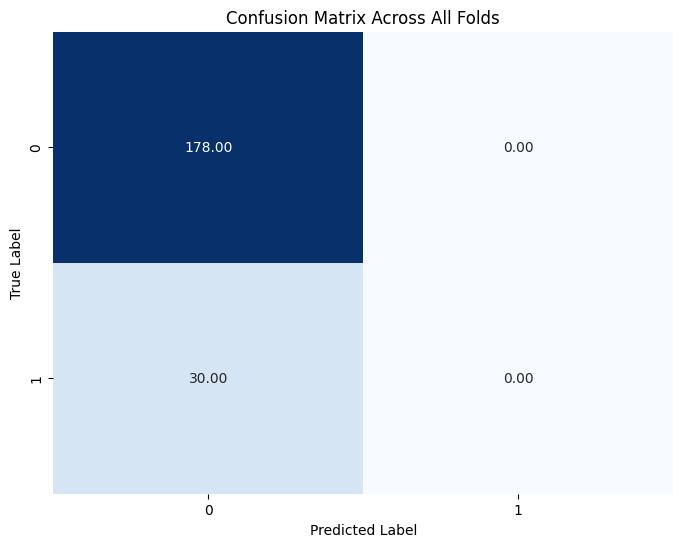


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.8558    1.0000    0.9223       178
           1     0.0000    0.0000    0.0000        30

    accuracy                         0.8558       208
   macro avg     0.4279    0.5000    0.4611       208
weighted avg     0.7323    0.8558    0.7893       208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Average Metrics Across Folds
avg_metrics = {
    key: np.mean([result[idx] for result in fold_results])
    for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])
}
avg_metrics['auc_roc'] = roc_auc  # Tambahkan AUC-ROC rata-rata

print("Average Metrics Across Folds:")
for key, value in avg_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# Calculate and plot the overall confusion matrix after all folds
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Across All Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report for All Folds
print("\nClassification Report for All Folds:")
print(classification_report(all_labels, all_preds, digits=4))


# **Visualisasi KFold Cross Validation**

## Hasil Data Default Without Hyperparameter Tuning

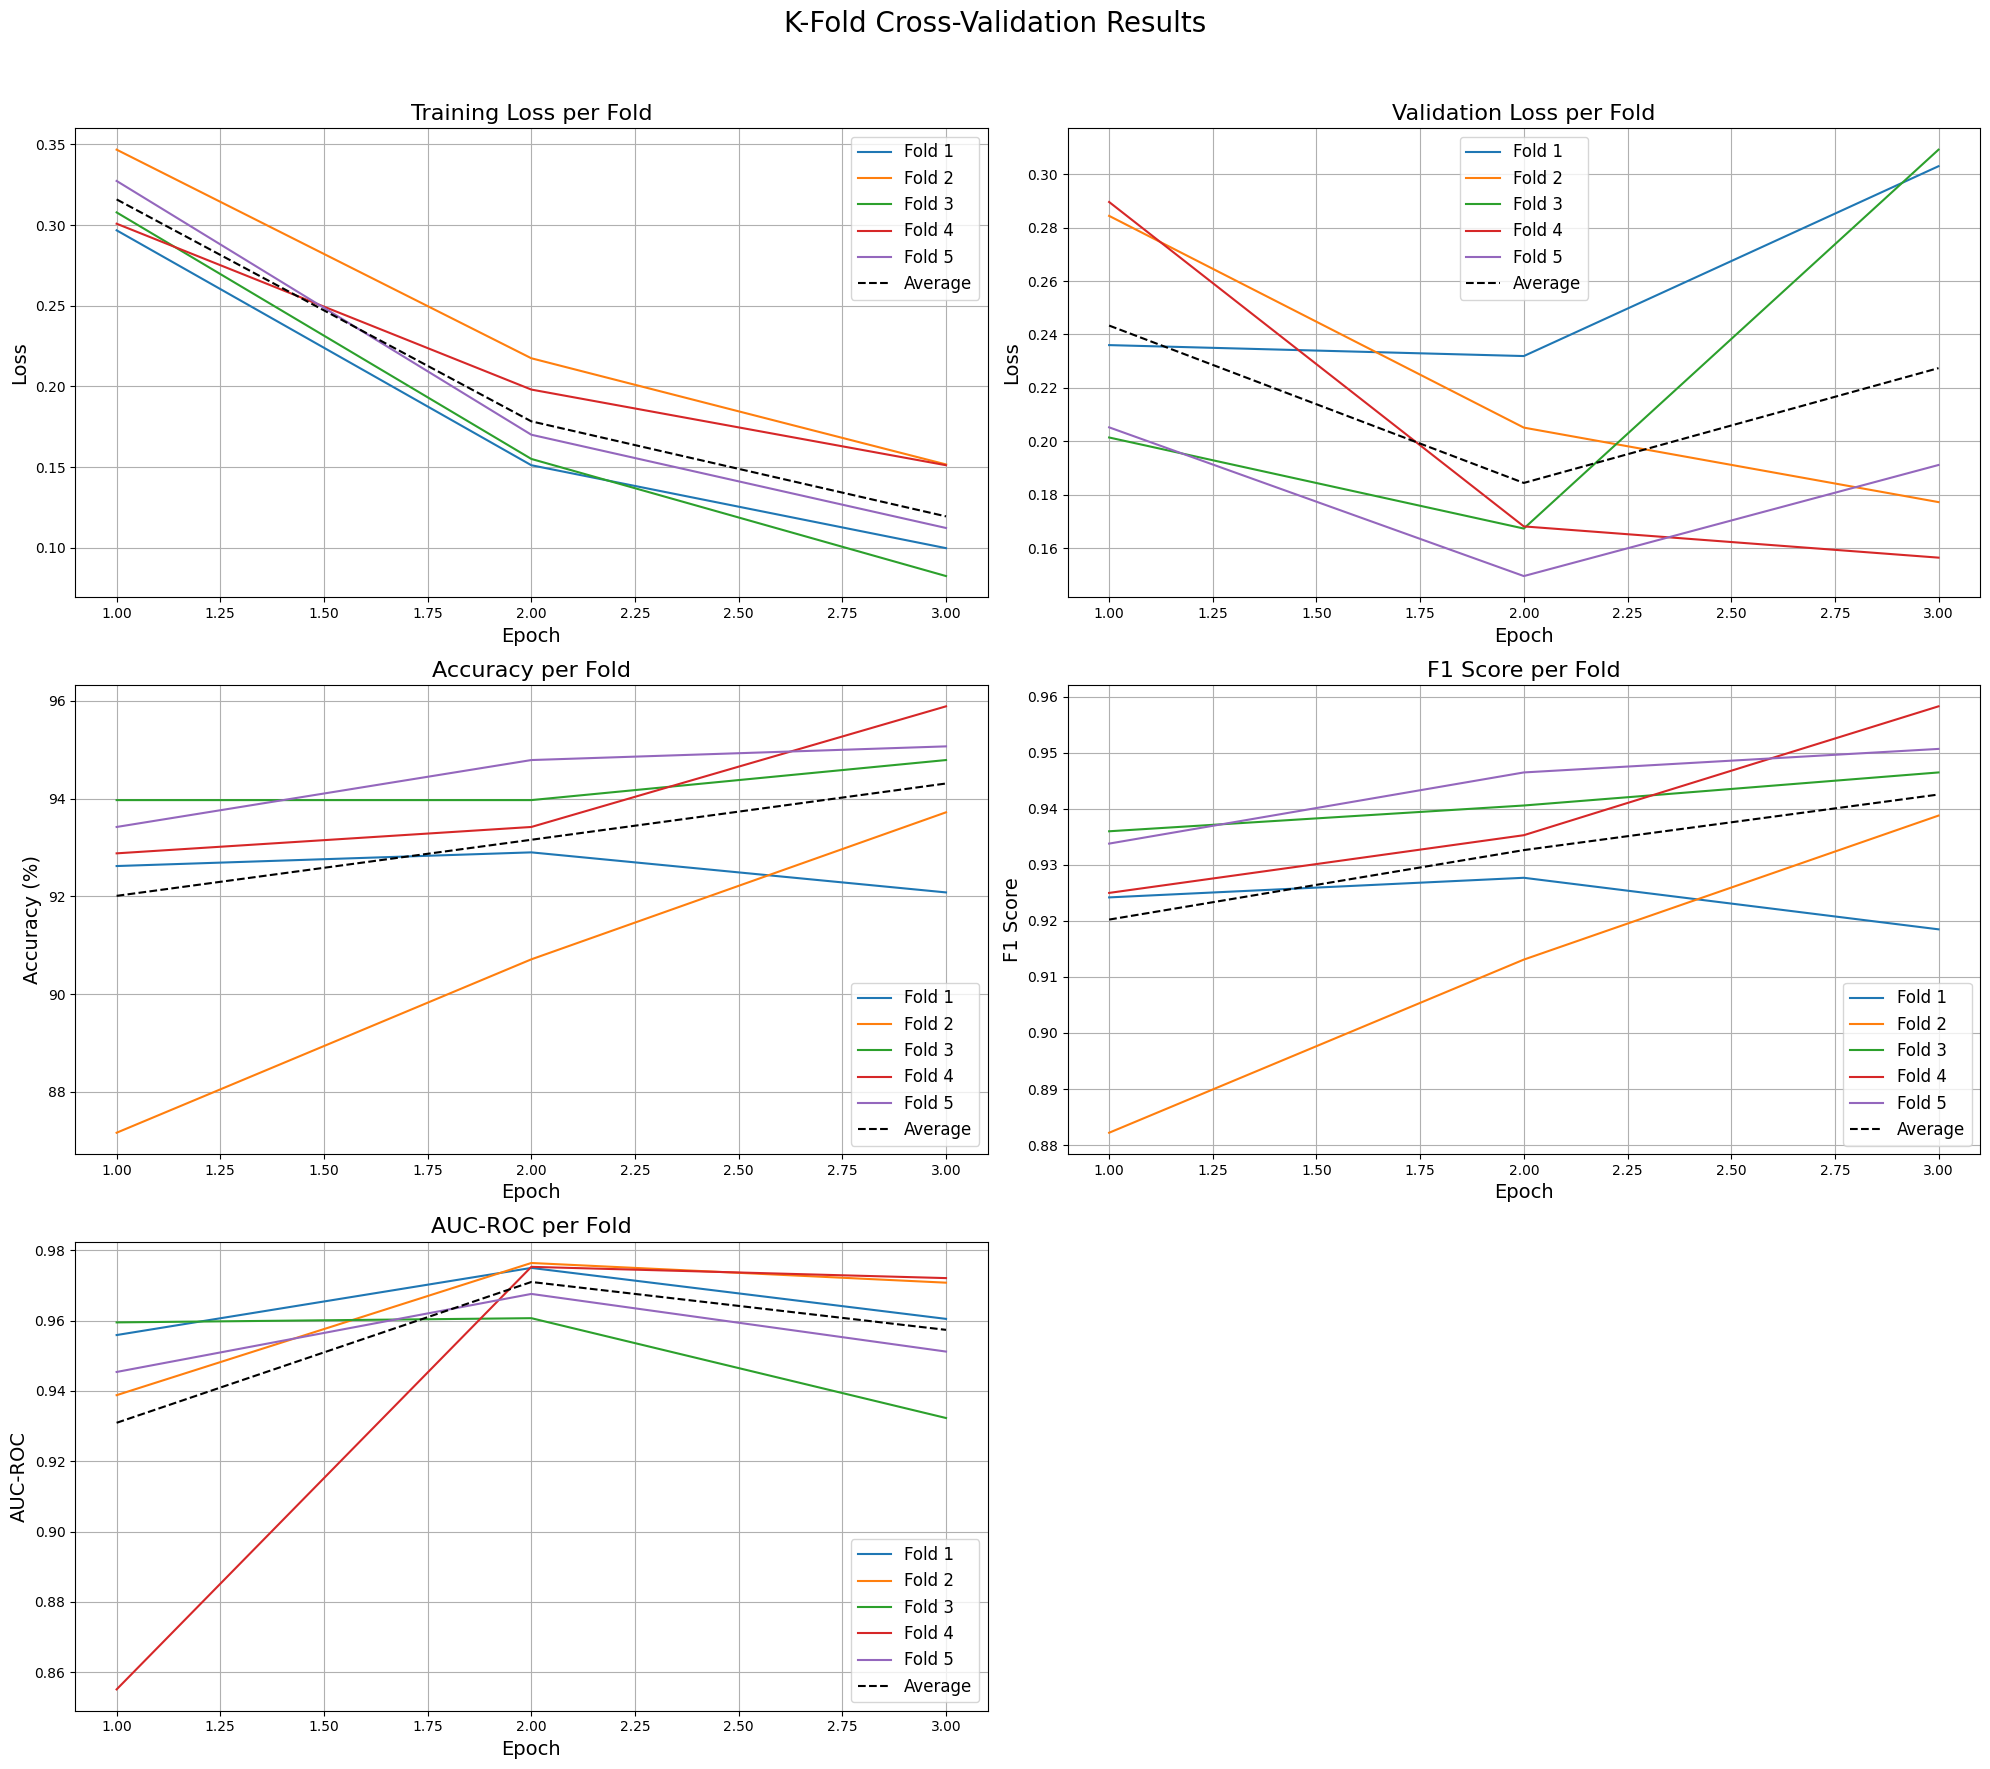

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data kinerja setiap fold berdasarkan log yang kamu berikan
folds = 5
epochs = [1, 2, 3]  # Jumlah epoch yang digunakan pada masing-masing fold
train_loss = [
    [0.2968, 0.1512, 0.0998],
    [0.3468, 0.2175, 0.1517],
    [0.3079, 0.1551, 0.0825],
    [0.3009, 0.1981, 0.1512],
    [0.3274, 0.1701, 0.1123]
]
val_loss = [
    [0.2360, 0.2319, 0.3030],
    [0.2844, 0.2051, 0.1772],
    [0.2014, 0.1673, 0.3092],
    [0.2896, 0.1681, 0.1564],
    [0.2052, 0.1495, 0.1911]
]
accuracy = [
    [92.62, 92.90, 92.08],
    [87.16, 90.71, 93.72],
    [93.97, 93.97, 94.79],
    [92.88, 93.42, 95.89],
    [93.42, 94.79, 95.07]
]
f1_score = [
    [0.9242, 0.9277, 0.9185],
    [0.8822, 0.9131, 0.9388],
    [0.9360, 0.9406, 0.9465],
    [0.9250, 0.9353, 0.9583],
    [0.9338, 0.9465, 0.9507]
]
auc_roc = [
    [0.9559, 0.9750, 0.9605],
    [0.9388, 0.9764, 0.9708],
    [0.9595, 0.9607, 0.9323],
    [0.8551, 0.9753, 0.9721],
    [0.9454, 0.9676, 0.9512]
]

# Rata-rata metrik di seluruh fold
avg_train_loss = np.mean(train_loss, axis=0)
avg_val_loss = np.mean(val_loss, axis=0)
avg_accuracy = np.mean(accuracy, axis=0)
avg_f1_score = np.mean(f1_score, axis=0)
avg_auc_roc = np.mean(auc_roc, axis=0)

# Plot untuk setiap fold dan rata-rata
fig, axs = plt.subplots(3, 2, figsize=(20, 18))

# Grafik Training Loss
for i in range(folds):
    axs[0, 0].plot(epochs, train_loss[i], label=f'Fold {i+1}')
axs[0, 0].plot(epochs, avg_train_loss, color='black', linestyle='--', label='Average')
axs[0, 0].set_title('Training Loss per Fold', fontsize=16)
axs[0, 0].set_xlabel('Epoch', fontsize=14)
axs[0, 0].set_ylabel('Loss', fontsize=14)
axs[0, 0].legend(loc='best', fontsize=12)
axs[0, 0].grid(True)

# Grafik Validation Loss
for i in range(folds):
    axs[0, 1].plot(epochs, val_loss[i], label=f'Fold {i+1}')
axs[0, 1].plot(epochs, avg_val_loss, color='black', linestyle='--', label='Average')
axs[0, 1].set_title('Validation Loss per Fold', fontsize=16)
axs[0, 1].set_xlabel('Epoch', fontsize=14)
axs[0, 1].set_ylabel('Loss', fontsize=14)
axs[0, 1].legend(loc='best', fontsize=12)
axs[0, 1].grid(True)

# Grafik Accuracy
for i in range(folds):
    axs[1, 0].plot(epochs, accuracy[i], label=f'Fold {i+1}')
axs[1, 0].plot(epochs, avg_accuracy, color='black', linestyle='--', label='Average')
axs[1, 0].set_title('Accuracy per Fold', fontsize=16)
axs[1, 0].set_xlabel('Epoch', fontsize=14)
axs[1, 0].set_ylabel('Accuracy (%)', fontsize=14)
axs[1, 0].legend(loc='best', fontsize=12)
axs[1, 0].grid(True)

# Grafik F1 Score
for i in range(folds):
    axs[1, 1].plot(epochs, f1_score[i], label=f'Fold {i+1}')
axs[1, 1].plot(epochs, avg_f1_score, color='black', linestyle='--', label='Average')
axs[1, 1].set_title('F1 Score per Fold', fontsize=16)
axs[1, 1].set_xlabel('Epoch', fontsize=14)
axs[1, 1].set_ylabel('F1 Score', fontsize=14)
axs[1, 1].legend(loc='best', fontsize=12)
axs[1, 1].grid(True)

# Grafik AUC-ROC
for i in range(folds):
    axs[2, 0].plot(epochs, auc_roc[i], label=f'Fold {i+1}')
axs[2, 0].plot(epochs, avg_auc_roc, color='black', linestyle='--', label='Average')
axs[2, 0].set_title('AUC-ROC per Fold', fontsize=16)
axs[2, 0].set_xlabel('Epoch', fontsize=14)
axs[2, 0].set_ylabel('AUC-ROC', fontsize=14)
axs[2, 0].legend(loc='best', fontsize=12)
axs[2, 0].grid(True)

# Kosongkan subplot terakhir
axs[2, 1].axis('off')

plt.suptitle('K-Fold Cross-Validation Results', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title better
plt.show()


### Summary

Fold 1:

Train Loss: 0.2159

Val Loss: 0.2563

Accuracy: 92.86%

F1 Score: 0.9235

AUC-ROC: 0.9638

.
Fold 2:

Train Loss: 0.2387

Val Loss: 0.2222

Accuracy: 90.86%

F1 Score: 0.9114

AUC-ROC: 0.9619

.
Fold 3:

Train Loss: 0.1552

Val Loss: 0.2260

Accuracy: 94.52%

F1 Score: 0.9410

AUC-ROC: 0.9508

.
Fold 4:

Train Loss: 0.2167

Val Loss: 0.2057

Accuracy: 93.73%

F1 Score: 0.9395

AUC-ROC: 0.9358

.
Fold 5:

Train Loss: 0.2033

Val Loss: 0.1786
Accuracy: 94.09%
F1 Score: 0.9436
AUC-ROC: 0.9547

### Kesimpulan
Berdasarkan perbandingan kinerja di atas:

Fold 1 memiliki Train Loss dan Val Loss terendah, serta Accuracy dan F1 Score tertinggi di antara ketiga fold. Ini menunjukkan bahwa Fold 1 memiliki kinerja terbaik dalam memprediksi dengan akurasi tinggi dan kesalahan terendah, baik pada data pelatihan maupun data validasi.

Fold 2 menonjol pada AUC-ROC yang lebih tinggi, menunjukkan kemampuannya dalam membedakan kelas, namun memiliki loss yang lebih tinggi dan akurasi yang lebih rendah.

Fold 3 menunjukkan hasil yang lebih stabil tetapi kurang unggul dibanding Fold 1 pada sebagian besar metrik.


**Fold terbaik adalah Fold 1, karena memiliki kombinasi terbaik dari loss terendah dan akurasi serta F1 score yang paling tinggi, yang menunjukkan keseimbangan antara performa pada training dan validation.**

## Hasil Data Default Without Hyperparameter Tuning

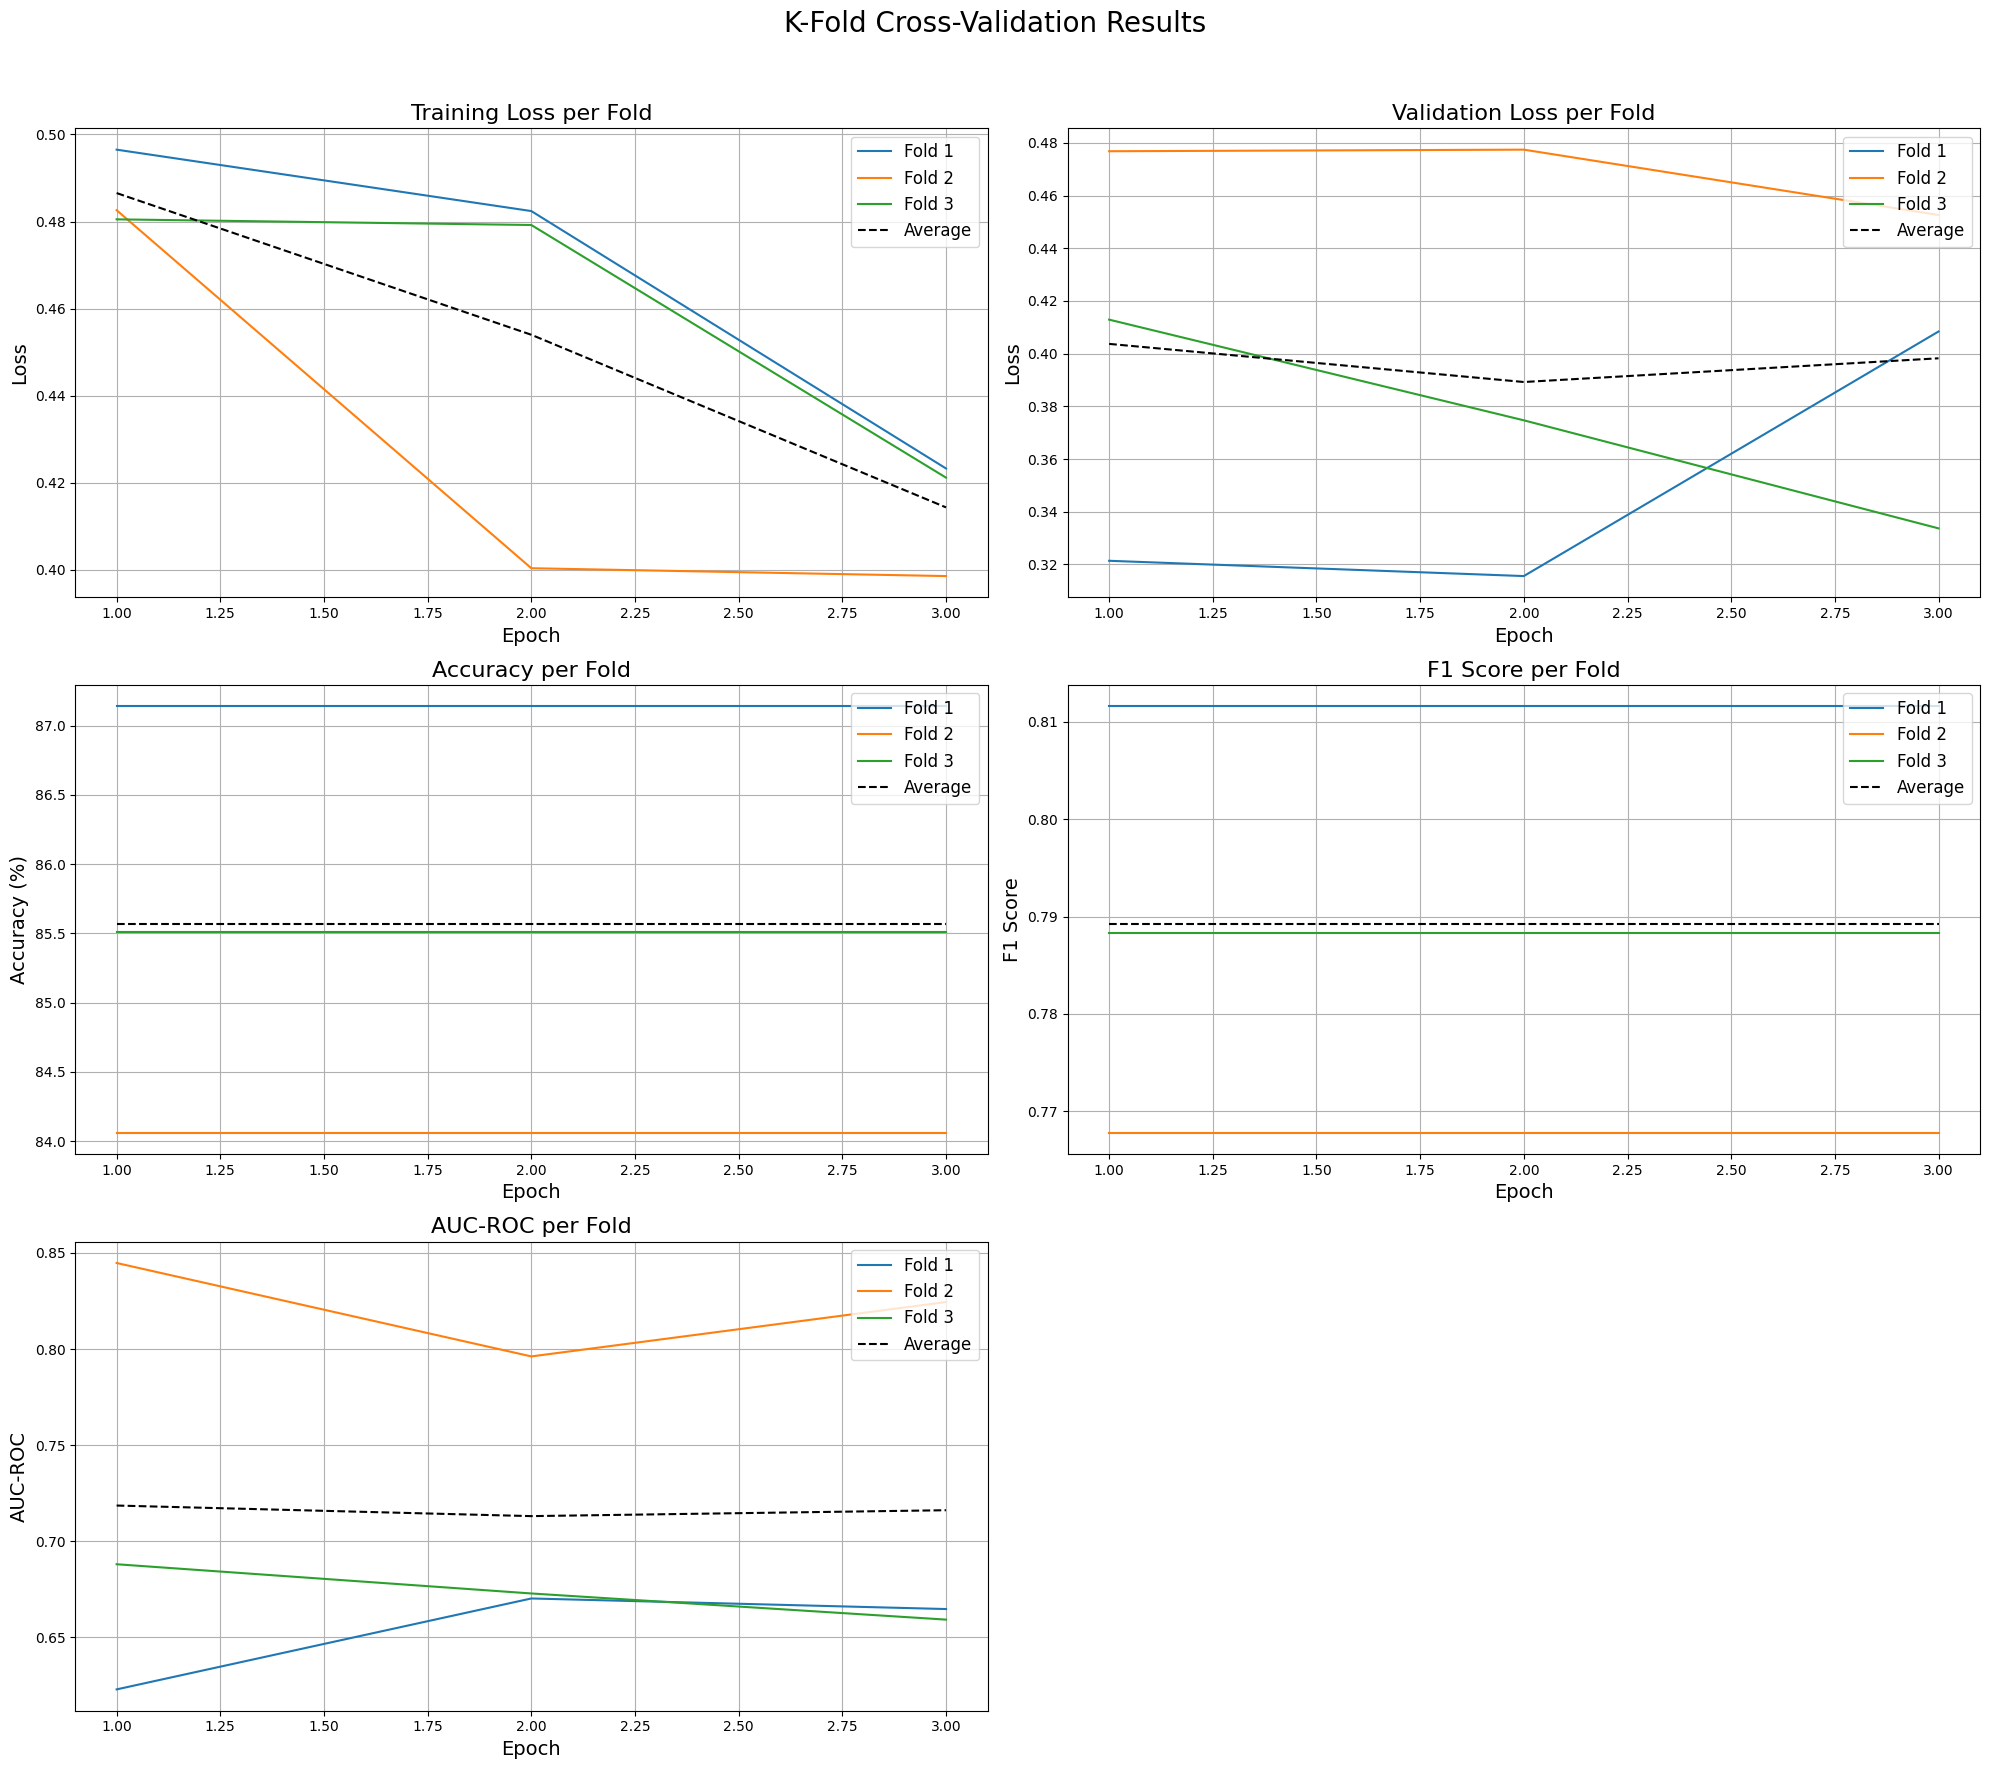

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data based on the new logs for each fold and epoch
folds = 3
epochs = [1, 2, 3]
train_loss = [
    [0.4965, 0.4824, 0.4233],
    [0.4826, 0.4004, 0.3986],
    [0.4805, 0.4792, 0.4212]
]
val_loss = [
    [0.3214, 0.3156, 0.4084],
    [0.4768, 0.4774, 0.4526],
    [0.4129, 0.3747, 0.3337]
]
accuracy = [
    [87.14, 87.14, 87.14],
    [84.06, 84.06, 84.06],
    [85.51, 85.51, 85.51]
]
f1_score = [
    [0.8116, 0.8116, 0.8116],
    [0.7678, 0.7678, 0.7678],
    [0.7883, 0.7883, 0.7883]
]
auc_roc = [
    [0.6230, 0.6703, 0.6648],
    [0.8448, 0.7962, 0.8245],
    [0.6881, 0.6729, 0.6593]
]

# Calculate averages across folds
avg_train_loss = np.mean(train_loss, axis=0)
avg_val_loss = np.mean(val_loss, axis=0)
avg_accuracy = np.mean(accuracy, axis=0)
avg_f1_score = np.mean(f1_score, axis=0)
avg_auc_roc = np.mean(auc_roc, axis=0)

# Plot each metric per epoch
fig, axs = plt.subplots(3, 2, figsize=(20, 18))

# Training Loss
for i in range(folds):
    axs[0, 0].plot(epochs, train_loss[i], label=f'Fold {i+1}')
axs[0, 0].plot(epochs, avg_train_loss, color='black', linestyle='--', label='Average')
axs[0, 0].set_title('Training Loss per Fold', fontsize=16)
axs[0, 0].set_xlabel('Epoch', fontsize=14)
axs[0, 0].set_ylabel('Loss', fontsize=14)
axs[0, 0].legend(loc='best', fontsize=12)
axs[0, 0].grid(True)

# Validation Loss
for i in range(folds):
    axs[0, 1].plot(epochs, val_loss[i], label=f'Fold {i+1}')
axs[0, 1].plot(epochs, avg_val_loss, color='black', linestyle='--', label='Average')
axs[0, 1].set_title('Validation Loss per Fold', fontsize=16)
axs[0, 1].set_xlabel('Epoch', fontsize=14)
axs[0, 1].set_ylabel('Loss', fontsize=14)
axs[0, 1].legend(loc='best', fontsize=12)
axs[0, 1].grid(True)

# Accuracy
for i in range(folds):
    axs[1, 0].plot(epochs, accuracy[i], label=f'Fold {i+1}')
axs[1, 0].plot(epochs, avg_accuracy, color='black', linestyle='--', label='Average')
axs[1, 0].set_title('Accuracy per Fold', fontsize=16)
axs[1, 0].set_xlabel('Epoch', fontsize=14)
axs[1, 0].set_ylabel('Accuracy (%)', fontsize=14)
axs[1, 0].legend(loc='best', fontsize=12)
axs[1, 0].grid(True)

# F1 Score
for i in range(folds):
    axs[1, 1].plot(epochs, f1_score[i], label=f'Fold {i+1}')
axs[1, 1].plot(epochs, avg_f1_score, color='black', linestyle='--', label='Average')
axs[1, 1].set_title('F1 Score per Fold', fontsize=16)
axs[1, 1].set_xlabel('Epoch', fontsize=14)
axs[1, 1].set_ylabel('F1 Score', fontsize=14)
axs[1, 1].legend(loc='best', fontsize=12)
axs[1, 1].grid(True)

# AUC-ROC
for i in range(folds):
    axs[2, 0].plot(epochs, auc_roc[i], label=f'Fold {i+1}')
axs[2, 0].plot(epochs, avg_auc_roc, color='black', linestyle='--', label='Average')
axs[2, 0].set_title('AUC-ROC per Fold', fontsize=16)
axs[2, 0].set_xlabel('Epoch', fontsize=14)
axs[2, 0].set_ylabel('AUC-ROC', fontsize=14)
axs[2, 0].legend(loc='best', fontsize=12)
axs[2, 0].grid(True)

# Hide the unused subplot
axs[2, 1].axis('off')

plt.suptitle('K-Fold Cross-Validation Results', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Summary

Fold 1:

Train Loss: 0.4674

Val Loss: 0.3486

Accuracy: 87.14

F1 Score: 0.8116

AUC-ROC: 0.6527

.

Fold 2:

Train Loss: 0.4272

Val Loss: 0.4523

Accuracy: 84.06

F1 Score: 0.7678

AUC-ROC: 0.8218

.

Fold 3:

Train Loss: 0.4603

Val Loss: 0.3738

Accuracy: 85.51

F1 Score: 0.7883

AUC-ROC: 0.6734

### Kesimpulan
Fold 1 menunjukkan performa terbaik dalam hal akurasi dan F1 score.
Fold 2 memiliki train loss terendah dan AUC-ROC tertinggi.
Fold 3 memiliki val loss yang baik, tetapi tidak sebaik Fold 1 dalam metrik lainnya.


**Fold terbaik adalah Fold 1, karena memiliki kombinasi terbaik dari loss terendah dan akurasi serta F1 score yang paling tinggi, yang menunjukkan keseimbangan antara performa pada training dan validation.**